In [1]:
#Astropy
import astropy
from astropy.io import fits
from astropy.table import Table

#emcee
import emcee
import corner as corner
import time

# Matplotlib
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline
matplotlib.rcParams.update({'font.size': 25})

#Numpy/Scipy
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
from scipy.interpolate import interp1d, interp2d
from scipy.optimize import curve_fit
from scipy.stats import binned_statistic, binned_statistic_2d

### TQDM
from tqdm import tqdm_notebook

In [2]:
def ghb_jk_teff(jk,feh):
    '''
    Calculate the photometric Teff of a star using Gonz\'{a}lez Hern\'{a}dez & Bonifacio 2009

    Input:
    -----
        jk: J - K color
    '''
    b = np.array([0.6517,0.6312,0.0168,-0.0381,0.0256,0.0013])

    theta_eff = b[0]+b[1]*jk+b[2]*(jk**2)+b[3]*(jk*feh)+b[4]*feh+b[5]*(feh**2)
    teff = 5040/theta_eff
    self.ghb_teff = teff
    return teff

def fitz_alebv(wave):
    '''
    Fitzpatrick 1999 extinction law
    '''
    recip_anchors = np.array([0.000,0.377,0.820,1.667,1.828,2.141,2.433,3.704,3.846])#[:-2]
    alebv_anchors = np.array([0.000,0.265,0.829,2.688,3.055,3.806,4.315,6.265,6.591])#[:-2]

    x=1/wave
    spl = interp1d(recip_anchors,alebv_anchors)
    alebv = spl(x)
    return alebv

leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757}
def ccm_a(x):
    '''
    a(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        a: a function value  
    '''
    if 0.3 <= x < 1.1:
        a = 0.574*(x**1.61)
        return a
    
    elif 1.1 <= x < 3.3:
        y = x - 1.82
        a = (1.+0.17699*y-0.50477*(y**2)-0.02427*(y**3)+0.72085*(y**4)+
                0.01979*(y**5)-0.77530*(y**6)+0.32999*(y**7))
        return a
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)
            return a
        
        else:
            fa = -0.04473*((x-5.9)**2)+0.1207*((x-5.9)**3)
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)+fa
            return a       
    
def ccm_b(x):
    '''
    b(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        b: b function value 
    '''
    if 0.3 <= x < 1.1:
        b = -0.527*(x**1.61)
        return b
    
    elif 1.1 <= x <= 3.3:
        y = x - 1.82
        b = (1.41338*y+2.28305*(y**2)+1.07233*(y**3)-5.38434*(y**4)-
                0.62251*(y**5)+5.30260*(y**6)-2.09002*(y**7))
        return b
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)
            return b
        
        else:
            fb = 0.2130*((x-5.9)**2)+0.1207*((x-5.9)**3)
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)+fb
            return b
    
def ccm_alav(wave,rv):
    '''
    Calculate A\lambda/Av
    
    Inputs:
    ------
        wave: effective wavelength in units of micron
        rv: Rv value (=Av/E(B_V))
        
    Output:
    ------
        alav: A\lambda/Av
    '''
    x=1/wave
    alav = ccm_a(x)+ccm_b(x)/rv
    return alav

ejk_ak = (ccm_alav(leff['J'],3.1)-ccm_alav(leff['K'],3.1))/ccm_alav(leff['K'],3.1)
ebv_ak = (ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))/ccm_alav(leff['K'],3.1)

def closest(data,value):
    '''
    Find nearest value in array to given value
        
    Inputs:
    ------
        data: data to search through 
        value: value of interest
    '''
        
    data = np.asarray(data)
    return data[(np.abs(np.subtract(data,value))).argmin()]

def neighbors(data,value):
    '''
    Find values of two elements closest to the given value

    Inputs:
    ------
        data: data to search through 
        value: value of interest

    Output:
    ------
        close1: closest value under the given value
        close2: closest value over the given value
    '''

    data = np.asarray(data)
    close1 = data[(np.abs(np.subtract(data,value))).argmin()]
    data = data[np.where(data!=close1)]
    close2 = data[(np.abs(np.subtract(data,value))).argmin()]

    return close1,close2

def mad(dat):
    return np.nanmedian(np.abs(dat-np.nanmedian(dat)))

abp_ebv = ccm_alav(leff['BP'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
arp_ebv = ccm_alav(leff['RP'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
aj_ebv = ccm_alav(leff['J'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
ah_ebv = ccm_alav(leff['H'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
ak_ebv = ccm_alav(leff['K'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))

# PARSEC

In [3]:
massive = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec_massive_lite.fits.gz')
massive = Table(massive[np.where(massive['label']==3.0)])
massive['index'] = np.arange(len(massive))
massive = massive[np.argsort(massive['logAge'])]
massive = massive['index','MH','Mass','logAge','logTe','logg','Gmag','G_BPmag','G_RPmag','Jmag','Hmag','Ksmag']

# APOGEE

In [4]:
dr17 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStar-dr17-synspec.fits.gz')
apoafe = dr17['ALPHA_M']+dr17['M_H']-dr17['FE_H']
apoafe_err = np.sqrt(dr17['ALPHA_M']**2+dr17['M_H']**2-dr17['FE_H']**2)

# 0.659, 0.341 from Asplund et al 2021.
salfeh = dr17['FE_H']+np.log10(0.659*(10**(apoafe))+0.341)
salfeh_err = np.sqrt(dr17['FE_H_ERR']**2+((1-0.341/(0.659*(10**(apoafe_err))+0.341))*apoafe)**2)

<ipython-input-4-c08ebd709588>:3: RuntimeWarning: invalid value encountered in sqrt
  apoafe_err = np.sqrt(dr17['ALPHA_M']**2+dr17['M_H']**2-dr17['FE_H']**2)


In [5]:
# https://iopscience.iop.org/article/10.3847/1538-3881/aba592/pdf

cn = dr17['FPARAM'][:,4]-dr17['FPARAM'][:,5]
dt = dr17['TEFF_SPEC'] - (4400.+552.6*(dr17['LOGG_SPEC']-2.5)-324.6*dr17['FPARAM'][:,3])

rc = dr17[np.where((dr17['FPARAM'][:,1]>2.38)&(dr17['FPARAM'][:,1]<3.5)&
                   (cn>0.04-0.46*dr17['FPARAM'][:,3]-0.0028*dt))]

rgb = dr17[np.where((dr17['FPARAM'][:,1]<3.5)&(dr17['FPARAM'][:,0]<6000.)&
                    (np.isin(dr17['APOGEE_ID'],rc['APOGEE_ID'])==False))]

rgb_salfeh = salfeh[np.where((dr17['FPARAM'][:,1]<3.5)&(dr17['FPARAM'][:,0]<6000.)&
                    (np.isin(dr17['APOGEE_ID'],rc['APOGEE_ID'])==False))]
rgb_salfeh_err = salfeh_err[np.where((dr17['FPARAM'][:,1]<3.5)&(dr17['FPARAM'][:,0]<6000.)&
                    (np.isin(dr17['APOGEE_ID'],rc['APOGEE_ID'])==False))]
rgb_apoafe = apoafe[np.where((dr17['FPARAM'][:,1]<3.5)&(dr17['FPARAM'][:,0]<6000.)&
                    (np.isin(dr17['APOGEE_ID'],rc['APOGEE_ID'])==False))]
rgb_apoafe_err = apoafe_err[np.where((dr17['FPARAM'][:,1]<3.5)&(dr17['FPARAM'][:,0]<6000.)&
                    (np.isin(dr17['APOGEE_ID'],rc['APOGEE_ID'])==False))]


# Get rid of stars with any ASPCAP flag and high extinction
rgb_salfeh[np.where((rgb['ASPCAPFLAG']==0))]
rgb_salfeh_err[np.where((rgb['ASPCAPFLAG']==0))]
rgb_apoafe[np.where((rgb['ASPCAPFLAG']==0))]
rgb_apoafe_err[np.where((rgb['ASPCAPFLAG']==0))]
rgb = rgb[np.where((rgb['ASPCAPFLAG']==0))]

# Gaia EDR3

In [6]:
gaiaedr3 = fits.getdata('/Users/joshuapovick/Desktop/Research/gaia/GAIAEDR3allStar.fits.gz')

In [102]:
a = np.array([1,2,3,4,0])
b = np.array([1,0,2,4,0]) 

a/b

# np.nan_to_num

<ipython-input-102-393861ae03ac>:4: RuntimeWarning: divide by zero encountered in true_divide
  a/b
<ipython-input-102-393861ae03ac>:4: RuntimeWarning: invalid value encountered in true_divide
  a/b


array([1. , inf, 1.5, 1. , nan])

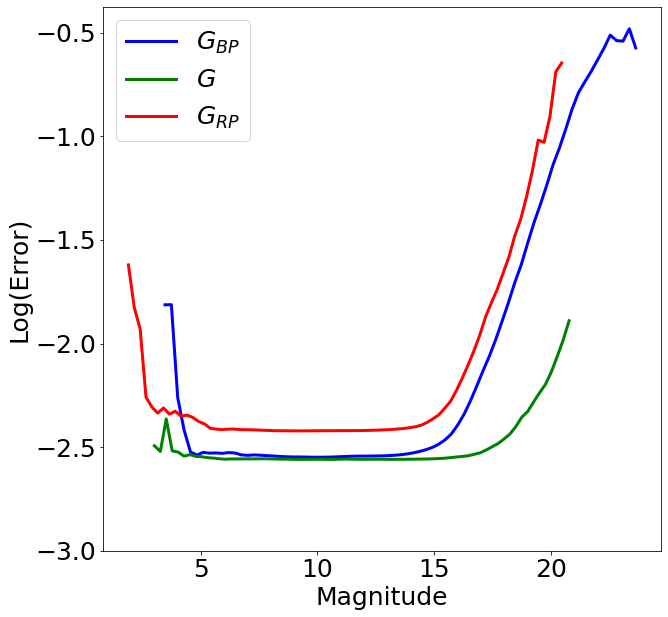

In [7]:
binnum = 75

### BP
bp_fin = np.where(np.isfinite(gaiaedr3['phot_bp_mean_mag'])==True)

bpmin = min(gaiaedr3['phot_bp_mean_mag'][bp_fin])
bpmax = max(gaiaedr3['phot_bp_mean_mag'][bp_fin])

bpdiff = bpmax-bpmin
bpfluxerr = (2.5*0.434)/gaiaedr3['phot_bp_mean_flux_over_error'][bp_fin]
bpmagerr = np.sqrt((bpfluxerr)**2+0.0027901700**2)

bpbin ,_,_ = binned_statistic(gaiaedr3['phot_bp_mean_mag'][bp_fin],np.log10(bpmagerr),'median',bins=binnum)

### G
g_fin = np.where(np.isfinite(gaiaedr3['phot_g_mean_mag'])==True)

gmin = min(gaiaedr3['phot_g_mean_mag'][g_fin])
gmax = max(gaiaedr3['phot_g_mean_mag'][g_fin])

gdiff = gmax-gmin
gfluxerr = (2.5*0.434)/gaiaedr3['phot_g_mean_flux_over_error'][g_fin]
gmagerr = np.sqrt((gfluxerr)**2+0.0027553202**2)

gbin ,_,_ = binned_statistic(gaiaedr3['phot_g_mean_mag'][g_fin],np.log10(gmagerr),'median',bins=binnum)

### RP 
rp_fin = np.where(np.isfinite(gaiaedr3['phot_rp_mean_mag'])==True)

rpmin = min(gaiaedr3['phot_rp_mean_mag'][rp_fin])
rpmax = max(gaiaedr3['phot_rp_mean_mag'][rp_fin])

rpdiff = rpmax-rpmin
rpfluxerr = (2.5*0.434)/gaiaedr3['phot_rp_mean_flux_over_error'][rp_fin]
rpmagerr = np.sqrt((rpfluxerr)**2+0.0037793818**2)

rpbin ,_,_ = binned_statistic(gaiaedr3['phot_rp_mean_mag'][rp_fin],np.log10(rpmagerr),'median',bins=binnum)

### Plot
plt.figure(figsize=[10,10])
plt.plot(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin,lw=3.0,c='blue',label=r'$G_{BP}$')
plt.plot(np.arange(gmin,gmax,gdiff/binnum),gbin,lw=3.0,c='green',label=r'$G$')
plt.plot(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin,lw=3.0,c='red',label=r'$G_{RP}$')
plt.legend()
plt.ylim(bottom=-3.0)
plt.xlabel('Magnitude')
plt.ylabel('Log(Error)')
plt.savefig('../plots/gaiaerrorcurve.pdf',dpi=300,bbox_inches='tight');

bperrfunc = IUS(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin)
gerrfunc = IUS(np.arange(gmin,gmax,gdiff/binnum),gbin)
rperrfunc = IUS(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin)

### Replace nan's with zeropoint error
bperr = np.nan_to_num(10**bperrfunc(rgb['GAIAEDR3_PHOT_BP_MEAN_MAG']),nan=0.0027901700)
gerr = np.nan_to_num(10**gerrfunc(rgb['GAIAEDR3_PHOT_G_MEAN_MAG']),nan=0.0027553202)
rperr = np.nan_to_num(10**rperrfunc(rgb['GAIAEDR3_PHOT_RP_MEAN_MAG']),nan=0.0037793818)

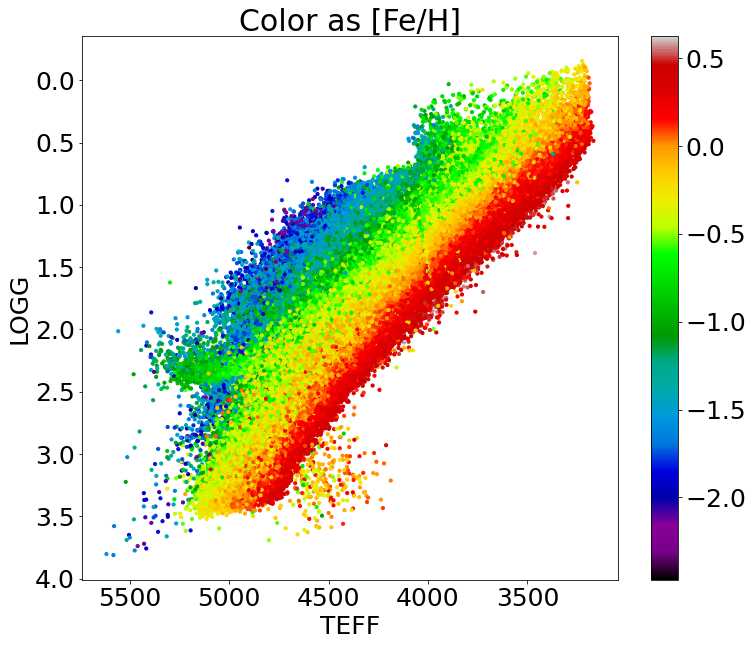

In [8]:
plt.figure(figsize=[12,10])
plt.scatter(rgb['TEFF'],rgb['LOGG'],c=rgb['FE_H'],cmap='nipy_spectral',s=10)
plt.colorbar()

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.title(r'Color as [Fe/H]')
plt.xlabel(r'TEFF')
plt.ylabel(r'LOGG');

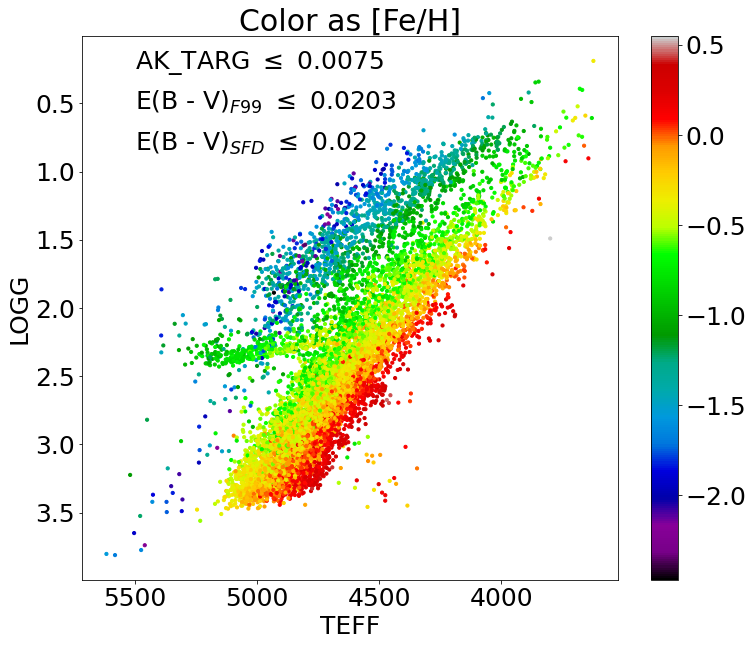

In [9]:
low_ak = np.where((rgb['AK_TARG']<=0.0075)&(rgb['SFD_EBV']<=0.02)&(rgb['J']-rgb['K']>0.25))

plt.figure(figsize=[12,10])
plt.scatter(rgb['TEFF'][low_ak],rgb['LOGG'][low_ak],c=rgb['FE_H'][low_ak],cmap='nipy_spectral',s=10)
plt.colorbar()

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.text(5500,0.25,r'AK_TARG $\leq$ 0.0075')
plt.text(5500,0.55,r'E(B - V)$_{F99}$ $\leq$ 0.0203')
plt.text(5500,0.85,r'E(B - V)$_{SFD}$ $\leq$ 0.02')

plt.title(r'Color as [Fe/H]')
plt.xlabel(r'TEFF')
plt.ylabel(r'LOGG');

In [10]:
def color_teff(obsphot,feh,isochrones,teff=None):
    
    '''
    Calculate the photometric Teff from PARSEC isochrones
    
    Inputs:
    ------
        obsphot: osberved photometry in BP, G, RP, J, H, and K with errors
        feh: salaris corrected [Fe/H]
        isochrones: table of PARSEC isochrones
        teff: (optional) Measured Teff of star
        
    Outputs:
    -------
        photteff: photometric temperature of star
        photteff_err: error in photometric temperature of star
    '''
    
    blues_iso = np.array(['G_BPmag','Gmag','Gmag','Gmag','Gmag']) 
    reds_iso = np.array(['Gmag','G_RPmag','Jmag','Hmag','Ksmag'])
    
    blues = np.array([obsphot[0,0],obsphot[1,0],obsphot[1,0],obsphot[1,0],obsphot[1,0]])
    reds = np.array([obsphot[1,0],obsphot[2,0],obsphot[3,0],obsphot[4,0],obsphot[5,0]])
    blues_err = np.array([obsphot[0,1],obsphot[1,1],obsphot[1,1],obsphot[1,1],obsphot[1,1]])
    reds_err = np.array([obsphot[1,1],obsphot[2,1],obsphot[3,1],obsphot[4,1],obsphot[5,1]])
    
    color_errs = np.sqrt(np.add(np.square(blues_err),np.square(reds_err)))
    
    if teff is not None:
        iso_ = isochrones[np.where((isochrones['MH']==closest(isochrones['MH'],feh))&
                               (isochrones['logTe']>np.log10(teff-500))&(isochrones['logTe']<np.log10(teff+500)))]
    else:
        iso_ = isochrones[np.where(isochrones['MH']==closest(isochrones['MH'],feh))]
    
    colorteffs = 999999.0*np.ones(5)
    colorteffs_err = 999999.0*np.ones(5)
    for i in range(5):
        sidx = np.argsort(iso_[blues_iso[i]]-iso_[reds_iso[i]])
        scolor = (iso_[blues_iso[i]]-iso_[reds_iso[i]])[sidx]
        _, uidx = np.unique(scolor,return_index=True)
        scolor = scolor[uidx]
        slogTe = iso_['logTe'][sidx][uidx]
        
        coeffs = np.polyfit(scolor,slogTe,7)
        poly = np.poly1d(coeffs)
        poly_deriv = np.poly1d(np.multiply(coeffs[:-1],np.arange(len(coeffs))[::-1][:-1]))
        
        colorteffs[i] = 10**poly(blues[i]-reds[i])
        sigma_poly = np.abs(poly_deriv(blues[i]-reds[i])*color_errs[i])
#         print('teff val',10**poly(blues[i]-reds[i]))
#         print('sig poly',sigma_poly)
#         print('color error',color_errs)
        colorteffs_err[i] = np.abs(colorteffs[i]*np.log(10)*sigma_poly*color_errs[i])
#         print('error',colorteffs_err[i])
#         colorteffs_err[i] = np.abs(10**(poly(blues[i]-reds[i])*color_errs[i]))
        
    wgts = np.square(np.reciprocal(colorteffs_err))
    wgts_sum = np.sum(wgts)
    
    photteff = np.dot(wgts,colorteffs)/wgts_sum
    photteff_err = np.sqrt(np.reciprocal(wgts_sum))
    
    return photteff, photteff_err

In [11]:
# do one [Fe/H] and save relation

In [12]:
# test_n = 5
# test_photteffs = 999999.0*np.ones(test_n)
# test_photteffs_err = 999999.0*np.ones(test_n)

# for i in tqdm_notebook(range(test_n)):
    
#     op = np.array([[rgb[low_ak]['GAIAEDR3_PHOT_BP_MEAN_MAG'][i],
#                     rgb[low_ak]['GAIAEDR3_PHOT_G_MEAN_MAG'][i],
#                     rgb[low_ak]['GAIAEDR3_PHOT_RP_MEAN_MAG'][i],
#                     rgb[low_ak]['J'][i],rgb[low_ak]['H'][i],
#                     rgb[low_ak]['K'][i]],
#                    [bperr[low_ak][i],gerr[low_ak][i],rperr[low_ak][i],
#                     rgb[low_ak]['J_ERR'][i],rgb[low_ak]['H_ERR'][i],
#                     rgb[low_ak]['K_ERR'][i]]]).T
    
#     test_photteffs[i],test_photteffs_err[i] = color_teff(op,rgb_salfeh[low_ak][i],
#                                                massive,teff=rgb[low_ak]['TEFF'][i])

In [13]:
# test_photteffs

In [14]:
# test_photteffs_err

In [15]:
# rgb[low_ak]['TEFF'][:5]

In [16]:
# ((test_photteffs-rgb[low_ak]['TEFF'][:5])/rgb[low_ak]['TEFF'][:5])*100

In [20]:
# photteffs = 999999.0*np.ones(len(np.squeeze(low_ak)))
# photteffs_err = 999999.0*np.ones(len(np.squeeze(low_ak)))

# for i in tqdm_notebook(range(len(np.squeeze(low_ak)))):
    
#     op = np.array([[rgb[low_ak]['GAIAEDR3_PHOT_BP_MEAN_MAG'][i],
#                     rgb[low_ak]['GAIAEDR3_PHOT_G_MEAN_MAG'][i],
#                     rgb[low_ak]['GAIAEDR3_PHOT_RP_MEAN_MAG'][i],
#                     rgb[low_ak]['J'][i],rgb[low_ak]['H'][i],
#                     rgb[low_ak]['K'][i]],
#                    [bperr[low_ak][i],gerr[low_ak][i],rperr[low_ak][i],
#                     rgb[low_ak]['J_ERR'][i],rgb[low_ak]['H_ERR'][i],
#                     rgb[low_ak]['K_ERR'][i]]]).T
    
#     photteffs[i],photteffs_err[i] = color_teff(op,rgb_salfeh[low_ak][i],
#                                                massive,teff=rgb[low_ak]['TEFF'][i])

<ipython-input-20-6a0f1a325c74>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(np.squeeze(low_ak)))):


<ipython-input-18-f204c27d8c0f>:48: RuntimeWarning: overflow encountered in double_scalars
  colorteffs[i] = 10**poly(blues[i]-reds[i])
<ipython-input-18-f204c27d8c0f>:49: RuntimeWarning: overflow encountered in double_scalars
  colorteffs_err[i] = np.abs(10**poly(blues[i]-reds[i])*color_errs[i])
<ipython-input-18-f204c27d8c0f>:51: RuntimeWarning: divide by zero encountered in reciprocal
  wgts = np.square(np.reciprocal(colorteffs_err))
<ipython-input-20-6a0f1a325c74>:15: RankWarning: Polyfit may be poorly conditioned
  photteffs[i],photteffs_err[i] = color_teff(op,rgb_salfeh[low_ak][i],
<ipython-input-20-6a0f1a325c74>:15: RankWarning: Polyfit may be poorly conditioned
  photteffs[i],photteffs_err[i] = color_teff(op,rgb_salfeh[low_ak][i],
<ipython-input-20-6a0f1a325c74>:15: RankWarning: Polyfit may be poorly conditioned
  photteffs[i],photteffs_err[i] = color_teff(op,rgb_salfeh[low_ak][i],
<ipython-input-20-6a0f1a325c74>:15: RankWarning: Polyfit may be poorly conditioned
  photteffs[i]

In [86]:
# photteffs_err

array([38946.05371915, 37957.13681776, 40702.73894997, ...,
       37001.14041171, 28765.1683908 , 27565.48928775])

In [17]:
# plt.figure(figsize=[12,10])
# plt.scatter(rgb[low_ak]['TEFF'],photteffs,c=rgb_salfeh[low_ak],cmap='nipy_spectral')
# plt.colorbar()
# plt.plot([3000,6000],[3000,6000],c='k',lw=3.0)
# plt.axhline(0.,c='k',lw=3.)
# plt.ylim(3000,6000)
# plt.xlim(3000,6000)

# plt.title(r'Color as Salaris [Fe/H]')
# plt.xlabel(r'TEFF')
# plt.ylabel(r'Photometric')

In [18]:
# plt.figure(figsize=[12,7])
# plt.scatter(rgb[low_ak]['FPARAM'][:,0],photteffs-rgb[low_ak]['TEFF'],c=rgb_salfeh[low_ak],cmap='nipy_spectral')
# plt.colorbar()
# plt.axhline(0.,c='k',lw=3.)
# plt.ylim(-300,200)

# plt.title(r'Color as Salaris [Fe/H]')
# plt.xlabel(r'FPARAM[:,0]')
# plt.ylabel(r'Photometric Teff - FPARAM[:,0]');

In [19]:
# fincut = np.where((np.isfinite(rgb[low_ak]['FPARAM'][:,0])==True)&(np.isfinite(photteffs)==True)&
#                   (np.isfinite(rgb_salfeh[low_ak])==True)&(photteffs-rgb[low_ak]['FPARAM'][:,0]>-300)&
#                   (photteffs-rgb[low_ak]['FPARAM'][:,0]<300))

# plt.figure(figsize=[12,7])

# ret = binned_statistic_2d(rgb[low_ak]['FPARAM'][:,0][fincut],(photteffs-rgb[low_ak]['FPARAM'][:,0])[fincut],
#                           rgb_salfeh[low_ak][fincut],'median',bins=50)
# im = plt.imshow(ret.statistic.T, origin='lower',
#                     extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
#                     aspect='auto',interpolation='nearest',cmap='nipy_spectral')

# plt.colorbar()
# plt.axhline(0.,c='k',lw=3.)
# plt.ylim(-200,300)

# plt.title(r'Color as Salaris Corrected [Fe/H]')
# plt.xlabel(r'FPARAM[:,0]')
# plt.ylabel(r'Photometric Teff - FPARAM[:,0]');

In [20]:
# plt.figure(figsize=[12,7])

# ret = binned_statistic_2d(rgb_salfeh[low_ak][fincut],(photteffs-rgb[low_ak]['FPARAM'][:,0])[fincut],
#                           rgb[low_ak]['FPARAM'][:,0][fincut],'median',bins=50)
# im = plt.imshow(ret.statistic.T, origin='lower',
#                     extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
#                     aspect='auto',interpolation='nearest',cmap='nipy_spectral')

# plt.colorbar()
# plt.axhline(0.,c='k',lw=3.)
# plt.ylim(-200,300)

# plt.xlabel(r'Salaris Corrected [Fe/H]')
# plt.title(r'Color as FPARAM[:,0]')
# plt.ylabel(r'Photometric Teff - FPARAM[:,0]');

# 2-3 Th

In [198]:
# Find all color teff relations 
length = len(np.unique(massive['MH']))

coeffs = np.empty((length,5),dtype=object)
coeffs_deriv = np.empty((length,5),dtype=object)

blues_iso = np.array(['G_BPmag','Gmag','Gmag','Gmag','Gmag']) 
reds_iso = np.array(['Gmag','G_RPmag','Jmag','Hmag','Ksmag'])

for i in tqdm_notebook(range(length)):
    isofeh = massive[np.where(massive['MH']==closest(massive['MH'],np.unique(massive['MH'])[i]))]
    
    for j in range(5):
        sidx = np.argsort(isofeh[blues_iso[j]]-isofeh[reds_iso[j]])
        scolor = (isofeh[blues_iso[j]]-isofeh[reds_iso[j]])[sidx]
        _, uidx = np.unique(scolor,return_index=True)
        scolor = scolor[uidx]
        slogTe = isofeh['logTe'][sidx][uidx]
        
        coeffs[i,j] = np.polyfit(scolor,slogTe,5)
        
#         coeffs1 = np.polyfit(scolor,10**slogTe,5)
#         resid_arr = -np.polyval(coeffs1,scolor)

        # second fit to residuals probably linear
        
        
#         coeffs_deriv[i,j] = np.multiply(coeffs[i,j][:-1],np.arange(len(coeffs[i,j]))[::-1][:-1])

<ipython-input-198-43d3c999fa94>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(length)):


In [208]:
# np.delete(self.obsphot[:,0]-self.obsphot[1,0],1)

test = np.array([[1,3,5,7,9],[2,4,5,6,8]]).T

new = np.delete(test[:,0] - test[1,0],1)
new[0] = -1*new[0]
new

array([2, 2, 4, 6])

In [227]:
test = np.array([['G_BPmag','Gmag','Gmag','Gmag','Gmag'],['Gmag','G_RPmag','Jmag','Hmag','Ksmag']]).T

print(test[0,0])
print(test[0,1])

G_BPmag
Gmag


In [237]:
def color_teff(obsphot,salfeh,isochrones,order=5):
    '''
    Calculate the Teff of a star using it's intrinsic color. This assumes either low extinction or dereddened 
    photometry.
    
    Inputs:
    ------
        obsphot:    6x2 array
                    array of observed photometry and associated errors
        
        salfeh:     float
                    Salaris corrected [Fe/H]
                    
        isochrones: Table
                    Table of isochrones
                    
        order:      int
                    order of polynomial to calculate 
    
    Outputs:
    -------
        teff:       float
                    photometric teff value calculated
                    
        teff_err:   float
                    error in the calculated 
    '''
    
#     blues_iso = np.array(['G_BPmag','Gmag','Gmag','Gmag','Gmag']) 
#     reds_iso = np.array(['Gmag','G_RPmag','Jmag','Hmag','Ksmag'])
    
    color_labels = np.array([['G_BPmag','Gmag','Gmag','Gmag','Gmag'],['Gmag','G_RPmag','Jmag','Hmag','Ksmag']]).T
    
    obs_colors = np.delete(obsphot[:,0]-obsphot[1,0],1)
    obs_colors[0] = -1*obs_colors[0]
    obs_colors_err = np.delete(np.sqrt(obsphot[:,1]**2+obsphot[1,1]**2),1)
    
    ### Fit color-Teff relation 
    
    # pick out isochrones with same [Fe/H] and cut very young and old ages
    iso = isochrones[np.where(isochrones['MH']==closest(isochrones['MH'],salfeh))]
    iso = iso[np.where((singfeh['logAge']<np.log10(10**10))&(singfeh['logAge']>np.log10(0.5*10**9)))]
    
    lgteffs = 999999.0*np.ones(5)
    lgteffs_err = np.copy(lgteffs)
    
    for i in range(5):
        
        # Interpolate the color-Teff relation
        #sidx = np.argsort(iso[blues_iso[i]]-iso[reds_iso[i]])
        #scolor = (iso[blues_iso[i]]-iso[reds_iso[i]])[sidx]
        
        sidx = np.argsort(iso[color_labels[i,0]]-iso[color_labels[i,1]])
        scolor = (iso[color_labels[i,0]]-iso[color_labels[i,1]])[sidx]
        _, uidx = np.unique(scolor,return_index=True)
        scolor = scolor[uidx]
        slogTe = iso['logTe'][sidx][uidx]
        
        coeffs = np.polyfit(scolor,slogTe,order)
        poly_color = np.poly1d(coeffs)
        poly_color_deriv = np.poly1d(np.multiply(coeffs[:-1],np.arange(len(coeffs))[::-1][:-1]))
        
        # Interolate a linear correction to the color-Teff relation
        corr_coeffs = np.polyfit(scolor,slogTe-poly_color(scolor),1)
        poly_corr = np.poly1d(corr_coeffs)
        poly_corr_deriv = np.poly1d(np.multiply(corr_coeffs[:-1],np.arange(len(corr_coeffs))[::-1][:-1]))
        
        # Calculate the Teff and error for the color-Teff relation
        lgteffs[i] = poly_color(obs_colors[i])+poly_corr(obs_colors[i])
        lgteffs_err[i] = np.sqrt(poly_color_deriv(obs_colors[i])**2+poly_corr_deriv(obs_colors[i])**2)
        
    # Calculate the weighted average to get the star's Teff and error
    wgts = np.square(np.reciprocal(lgteffs_err))
    wgts_sum = np.sum(wgts)
    
    lgteff = np.dot(wgts,lgteffs)/wgts_sum
    lgteff_err = np.sqrt(np.reciprocal(wgts_sum))
    
    teff = 10**lgteff
    teff_err = np.abs(teff*np.log(10)*lgteff_err)
    
    return np.array([teff,teff_err],dtype='object')

In [202]:
n=50
singfeh = massive[np.where(massive['MH']==closest(massive['MH'],np.unique(massive['MH'])[n]))]

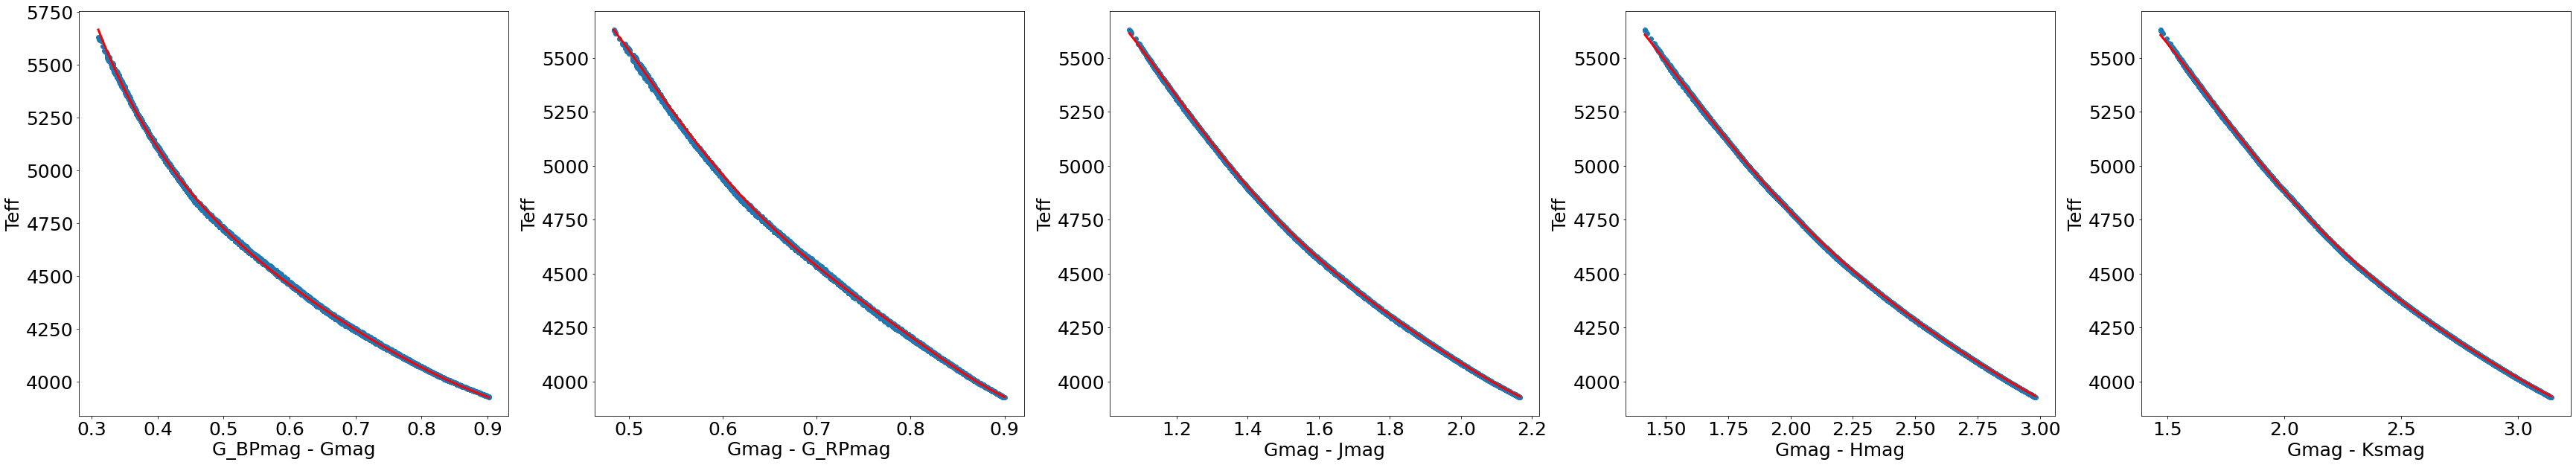

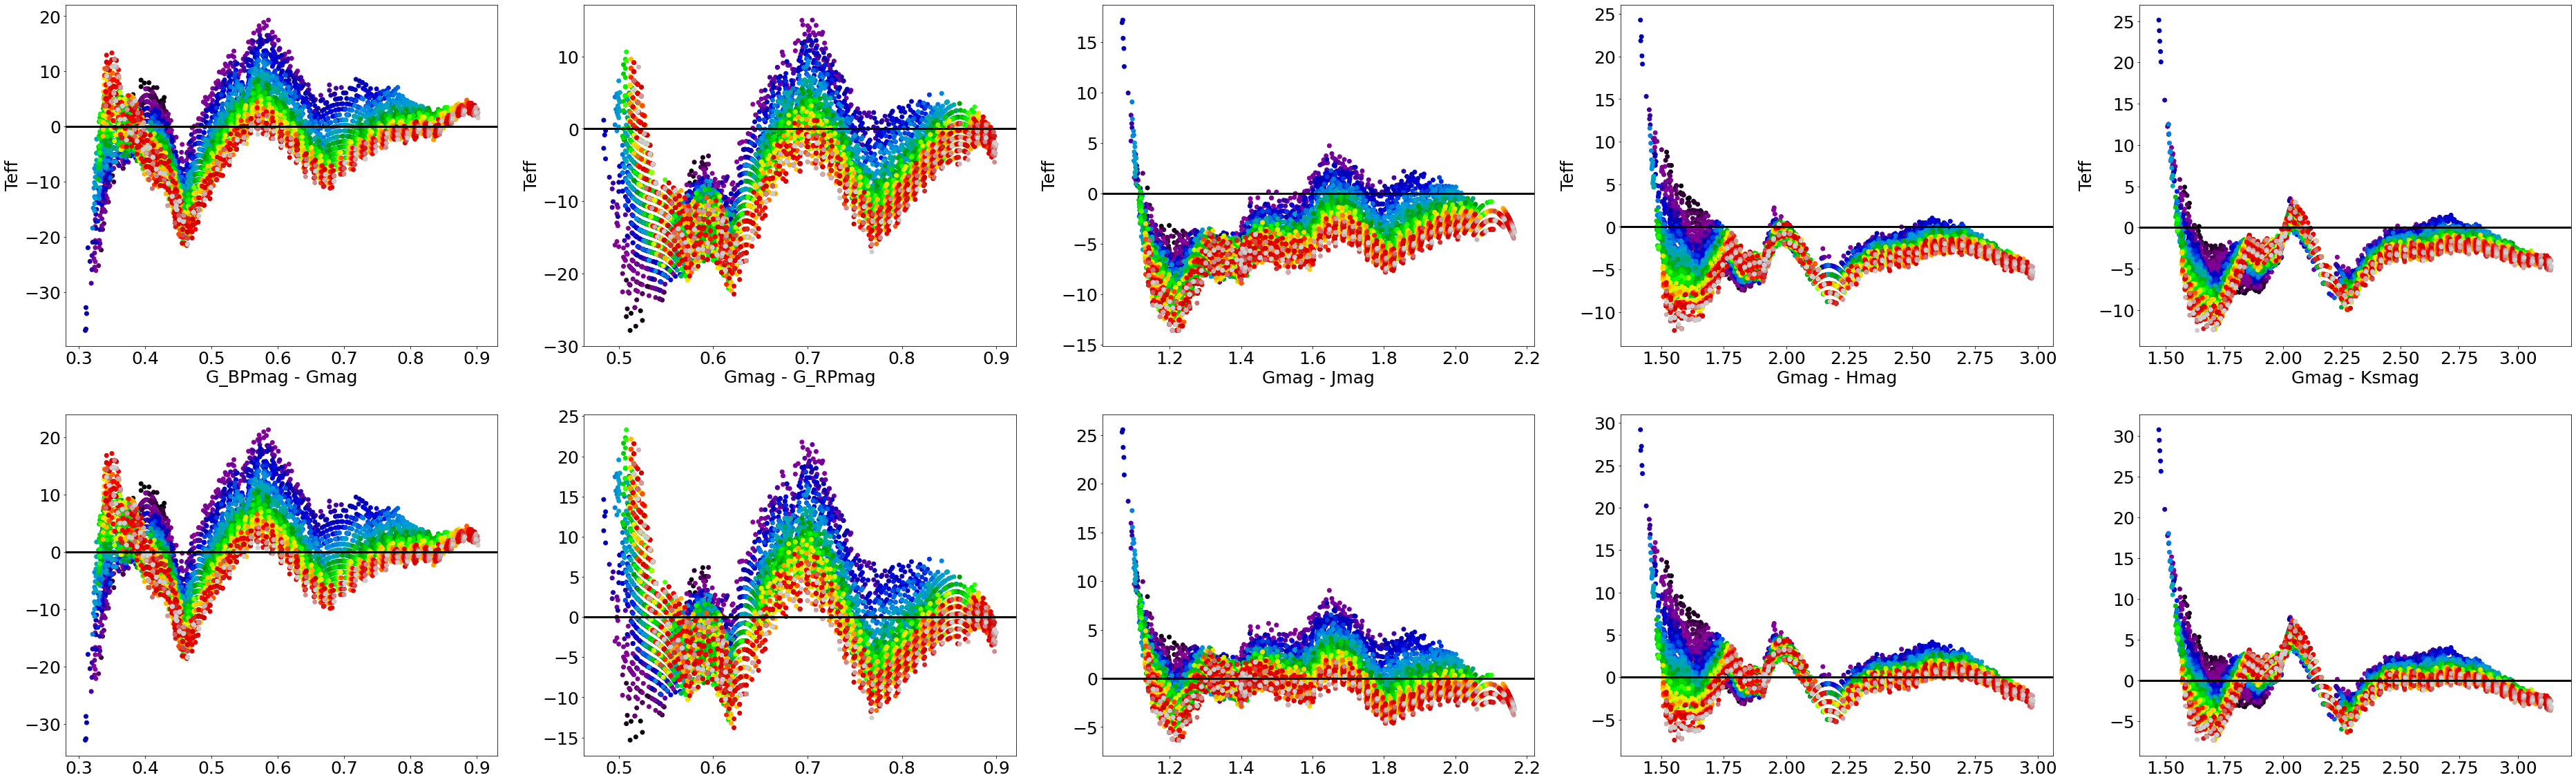

In [218]:
singfeh2 = singfeh[np.where((singfeh['logAge']<np.log10(10**10))&(singfeh['logAge']>np.log10(0.5*10**9)))]

blues_iso = np.array(['G_BPmag','Gmag','Gmag','Gmag','Gmag']) 
reds_iso = np.array(['Gmag','G_RPmag','Jmag','Hmag','Ksmag'])

fig,ax = plt.subplots(1,5,figsize=[60,10])
for i in range(5):

    ax[i].scatter(singfeh2[blues_iso[i]]-singfeh2[reds_iso[i]],10**singfeh2['logTe'])
    xs_colors = np.linspace(min(singfeh2[blues_iso[i]]-singfeh2[reds_iso[i]]),
                            max(singfeh2[blues_iso[i]]-singfeh2[reds_iso[i]]))
    ax[i].plot(xs_colors,10**np.poly1d(coeffs[n,i])(xs_colors),c='r',lw=3.0)
    ax[i].set_xlabel(r'{} - {}'.format(blues_iso[i],reds_iso[i]))
    ax[i].set_ylabel(r'Teff')
plt.show()

fig,ax = plt.subplots(2,5,figsize=[65,20])
for i in range(5):
    
    ###
    ax[0,i].scatter(singfeh2[blues_iso[i]]-singfeh2[reds_iso[i]],
                  10**singfeh2['logTe']-10**np.poly1d(coeffs[n,i])(singfeh2[blues_iso[i]]-singfeh2[reds_iso[i]]),
                  c=10**singfeh2['logAge']/10**9,cmap='nipy_spectral')

    ax[0,i].axhline(0.0,c='k',lw=3.0)
    ax[0,i].set_xlabel(r'{} - {}'.format(blues_iso[i],reds_iso[i]))
    ax[0,i].set_ylabel(r'Teff')
    
    ###
    corr = np.poly1d(np.polyfit(singfeh2[blues_iso[i]]-singfeh2[reds_iso[i]],
                                10**singfeh2['logTe']-10**np.poly1d(coeffs[n,i])(singfeh2[blues_iso[i]]-singfeh2[reds_iso[i]]),1))
    
    ax[1,i].scatter(singfeh2[blues_iso[i]]-singfeh2[reds_iso[i]],
                  10**singfeh2['logTe']-10**np.poly1d(coeffs[n,i])(singfeh2[blues_iso[i]]-singfeh2[reds_iso[i]])-corr(singfeh2[blues_iso[i]]-singfeh2[reds_iso[i]]),
                  c=10**singfeh2['logAge']/10**9,cmap='nipy_spectral')
    
    ax[1,i].axhline(0.0,c='k',lw=3.0)
# plt.colorbar(sc)
plt.show()

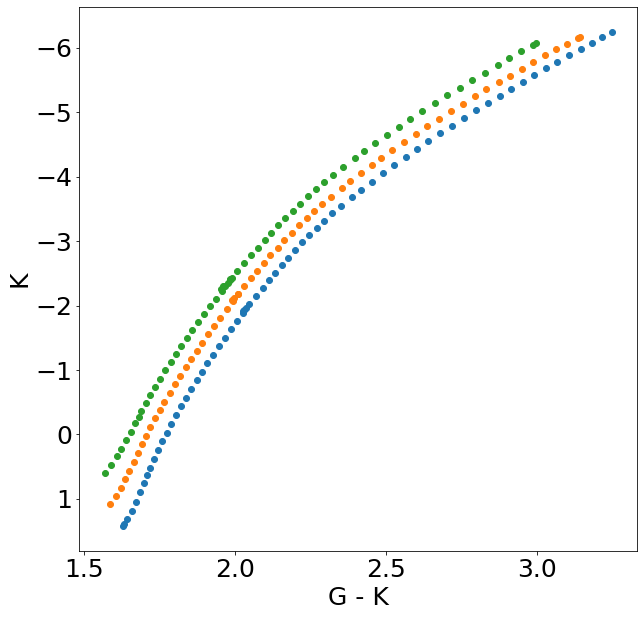

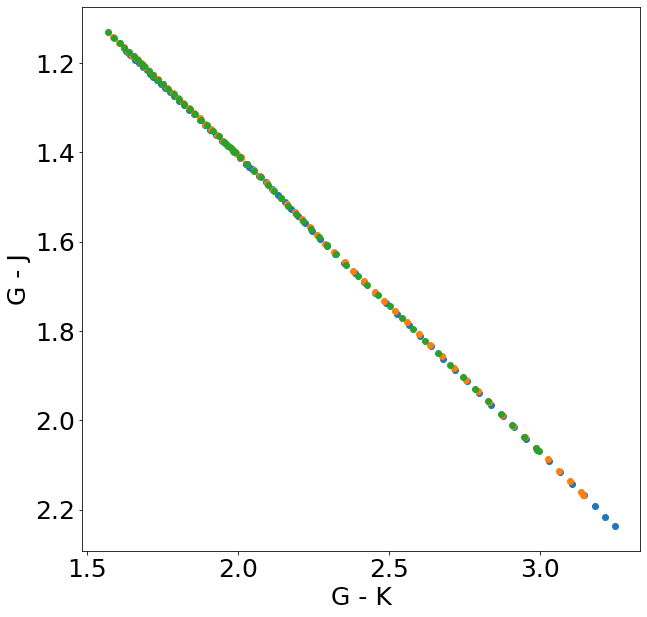

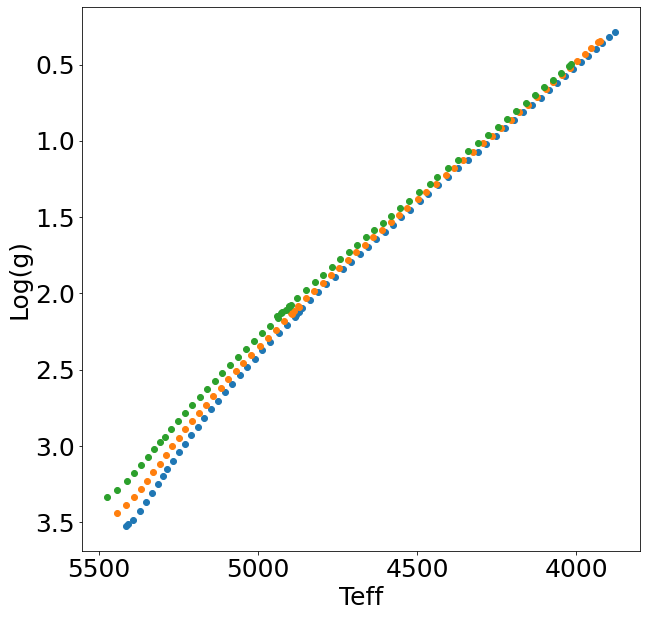

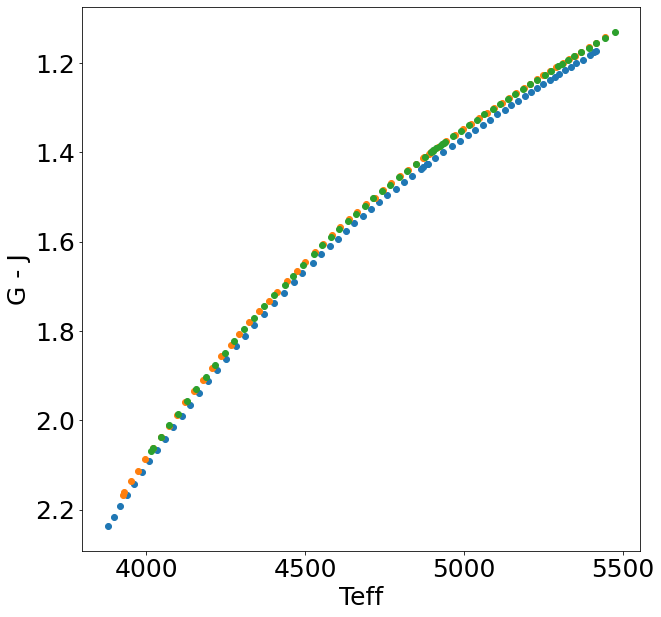

In [187]:
sixteen = singfeh[np.where(singfeh['logAge']==closest(singfeh['logAge'],np.log10(16*10**9)))]
ten = singfeh[np.where(singfeh['logAge']==closest(singfeh['logAge'],np.log10(10*10**9)))]
five = singfeh[np.where(singfeh['logAge']==closest(singfeh['logAge'],np.log10(5*10**9)))]

plt.figure(figsize=[10,10])
plt.scatter(sixteen['Gmag']-sixteen['Ksmag'],sixteen['Ksmag'])
plt.scatter(ten['Gmag']-ten['Ksmag'],ten['Ksmag'])
plt.scatter(five['Gmag']-five['Ksmag'],five['Ksmag'])
plt.gca().invert_yaxis()

plt.xlabel(r'G - K')
plt.ylabel(r'K');

plt.figure(figsize=[10,10])
plt.scatter(sixteen['Gmag']-sixteen['Ksmag'],sixteen['Gmag']-sixteen['Jmag'])
plt.scatter(ten['Gmag']-ten['Ksmag'],ten['Gmag']-ten['Jmag'])
plt.scatter(five['Gmag']-five['Ksmag'],five['Gmag']-five['Jmag'])
plt.gca().invert_yaxis()

plt.xlabel(r'G - K')
plt.ylabel(r'G - J');

plt.figure(figsize=[10,10])
plt.scatter(10**sixteen['logTe'],sixteen['logg'])
plt.scatter(10**ten['logTe'],ten['logg'])
plt.scatter(10**five['logTe'],five['logg'])

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.xlabel(r'Teff')
plt.ylabel(r'Log(g)');

plt.figure(figsize=[10,10])
plt.scatter(10**sixteen['logTe'],sixteen['Gmag']-sixteen['Jmag'])
plt.scatter(10**ten['logTe'],ten['Gmag']-ten['Jmag'])
plt.scatter(10**five['logTe'],five['Gmag']-five['Jmag'])
plt.gca().invert_yaxis()

plt.xlabel(r'Teff')
plt.ylabel(r'G - J');

In [118]:
photteff = 999999.0*np.ones(len(np.squeeze(low_ak)))
photteff_err = 999999.0*np.ones(len(np.squeeze(low_ak)))

for i in tqdm_notebook(range(len(np.squeeze(low_ak)))):
    
    feh_idx = np.squeeze(np.where(np.unique(massive['MH'])==closest(np.unique(massive['MH']),salfeh[i])))
    
    te = np.array(rgb[low_ak]['TEFF'][i],rgb[low_ak]['TEFF_ERR'][i])
    op = np.array([[rgb[low_ak]['GAIAEDR3_PHOT_BP_MEAN_MAG'][i],
                    rgb[low_ak]['GAIAEDR3_PHOT_G_MEAN_MAG'][i],
                    rgb[low_ak]['GAIAEDR3_PHOT_RP_MEAN_MAG'][i],
                    rgb[low_ak]['J'][i],rgb[low_ak]['H'][i],
                    rgb[low_ak]['K'][i]],
                   [bperr[low_ak][i],gerr[low_ak][i],rperr[low_ak][i],
                    rgb[low_ak]['J_ERR'][i],rgb[low_ak]['H_ERR'][i],
                    rgb[low_ak]['K_ERR'][i]]]).T
    
    blues = np.array([op[0,0],op[1,0],op[1,0],op[1,0],op[1,0]])
    reds = np.array([op[1,0],op[2,0],op[3,0],op[4,0],op[5,0]])
    
    blues_err = np.array([op[0,1],op[1,1],op[1,1],op[1,1],op[1,1]])
    reds_err = np.array([op[1,1],op[2,1],op[3,1],op[4,1],op[5,1]])
    
    color_errs = np.sqrt(np.add(np.square(blues_err),np.square(reds_err)))
    
    colorteffs = 999999.0*np.ones(5)
    colorteffs_err = 999999.0*np.ones(5)
    for j in range(5):
        poly = np.poly1d(coeffs[feh_idx,j])
        poly_deriv = np.poly1d(coeffs_deriv[feh_idx,j])
        sigma_poly = np.abs(poly_deriv(blues[j]-reds[j])*color_errs[j])
        colorteffs[j] = poly(blues[j]-reds[j])
        colorteffs_err[j] = np.abs(sigma_poly)
        
    wgts = np.square(np.reciprocal(colorteffs_err))
    wgts_sum = np.sum(wgts)
    
    photteff[i] = np.dot(wgts,colorteffs)/wgts_sum
    photteff_err[i] = np.sqrt(np.reciprocal(wgts_sum))

<ipython-input-118-04d689dc39cf>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(np.squeeze(low_ak)))):


In [238]:
photteffs = 999999.0*np.ones(len(np.squeeze(low_ak)))
photteffs_err = 999999.0*np.ones(len(np.squeeze(low_ak)))

for i in tqdm_notebook(range(len(np.squeeze(low_ak)))):
    
    te = np.array(rgb[low_ak]['TEFF'][i],rgb[low_ak]['TEFF_ERR'][i])
    op = np.array([[rgb[low_ak]['GAIAEDR3_PHOT_BP_MEAN_MAG'][i],
                    rgb[low_ak]['GAIAEDR3_PHOT_G_MEAN_MAG'][i],
                    rgb[low_ak]['GAIAEDR3_PHOT_RP_MEAN_MAG'][i],
                    rgb[low_ak]['J'][i],rgb[low_ak]['H'][i],
                    rgb[low_ak]['K'][i]],
                   [bperr[low_ak][i],gerr[low_ak][i],rperr[low_ak][i],
                    rgb[low_ak]['J_ERR'][i],rgb[low_ak]['H_ERR'][i],
                    rgb[low_ak]['K_ERR'][i]]]).T
    
    photteffs[i], photteffs_err[i] = color_teff(op,salfeh[i],massive,order=5)

<ipython-input-238-569aa06f9c8a>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(np.squeeze(low_ak)))):


332.2899775395779
979.2424807605014
3037.965788330462
6350.909198789747
2301.276218195679
0.09569686108144125
969.2879102822269
15410.762368223961
4796.734445315564
335.80992101440864
1111.4140128627012



KeyboardInterrupt: 

In [223]:
photteffs

array([1.01570810e-016, 2.36518925e-220, 3.57818448e+120, ...,
       9.99999000e+005, 9.99999000e+005, 9.99999000e+005])

In [148]:
### save ages to fits file
from astropy.table import Table, Column

cname = Column(rgb[low_ak]['APOGEE_ID'], name='NAME')
cteff = Column(photteff,name='PHOTTEFF')
ctefferr = Column(photteff_err,name='PHOTTEFF_ERR')

agetable = Table([cname,cteff,ctefferr])
agetable.write('photteff_lowext.fits', format='fits')#, overwrite=True)

In [23]:
photteff = fits.getdata('photteff_lowext.fits')
photteff.columns

ColDefs(
    name = 'NAME'; format = '30A'
    name = 'PHOTTEFF'; format = 'D'
    name = 'PHOTTEFF_ERR'; format = 'D'
)

Text(0, 0.5, 'PARSEC Photometric Teff')

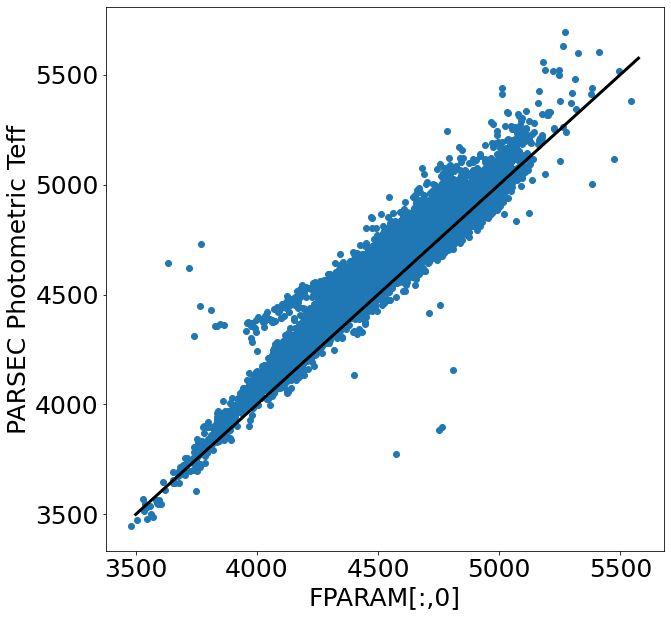

In [24]:
plt.figure(figsize=[10,10])
plt.scatter(rgb[low_ak]['FPARAM'][:,0],photteff['PHOTTEFF'])
plt.plot([3500,5575],[3500,5575],c='k',lw=3.)

plt.xlabel(r'FPARAM[:,0]')
plt.ylabel(r'PARSEC Photometric Teff')

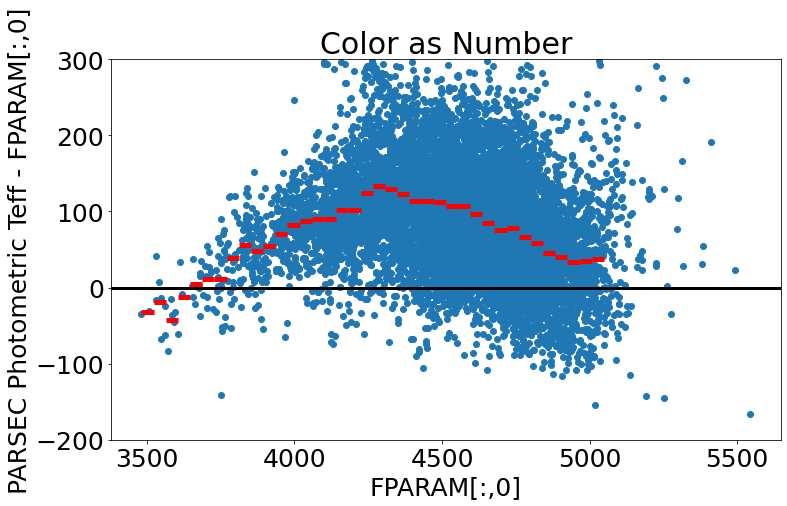

In [31]:
fincut = np.where((np.isfinite(rgb[low_ak]['FPARAM'][:,0])==True)&(np.isfinite(photteff['PHOTTEFF'])==True)&
                  (np.isfinite(rgb_salfeh[low_ak])==True)&(photteff['PHOTTEFF']-rgb[low_ak]['FPARAM'][:,0]>-300)&
                  (photteff['PHOTTEFF']-rgb[low_ak]['FPARAM'][:,0]<300))

plt.figure(figsize=[12,7])

meds,edgs,_ = binned_statistic(rgb[low_ak]['FPARAM'][:,0][fincut],(photteff['PHOTTEFF']-rgb[low_ak]['FPARAM'][:,0])[fincut],
                               bins=50)

cens = edgs[:-1]+np.median(np.diff(edgs)/2)

plt.scatter(rgb[low_ak]['FPARAM'][:,0][fincut],(photteff['PHOTTEFF']-rgb[low_ak]['FPARAM'][:,0])[fincut])

teff_right = -12
plt.hlines(meds[:teff_right], edgs[:-1][:teff_right], edgs[1:][:teff_right], colors='r', lw=5.)

# plt.colorbar()
plt.axhline(0.,c='k',lw=3.)
plt.ylim(-200,300)

plt.title(r'Color as Number')
plt.xlabel(r'FPARAM[:,0]')
plt.ylabel(r'PARSEC Photometric Teff - FPARAM[:,0]');

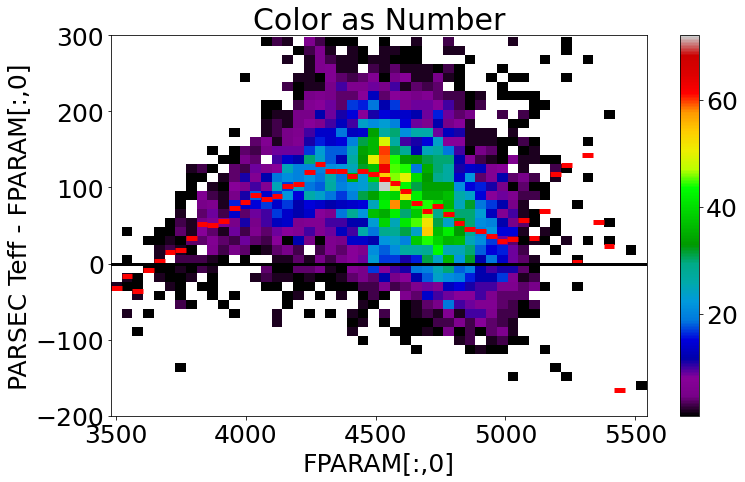

In [41]:
fincut = np.where((np.isfinite(rgb[low_ak]['FPARAM'][:,0])==True)&(np.isfinite(photteff['PHOTTEFF'])==True)&
                  (np.isfinite(rgb_salfeh[low_ak])==True)&(photteff['PHOTTEFF']-rgb[low_ak]['FPARAM'][:,0]>-300)&
                  (photteff['PHOTTEFF']-rgb[low_ak]['FPARAM'][:,0]<300))

plt.figure(figsize=[12,7])

teffmeds,teffedgs,teffnums = binned_statistic(rgb[low_ak]['FPARAM'][:,0][fincut],(photteff['PHOTTEFF']-rgb[low_ak]['FPARAM'][:,0])[fincut],
                               statistic='median',bins=50)
teffcens = teffedgs[:-1]+np.median(np.diff(teffedgs))/2.

teffcens=teffcens[np.where(np.isfinite(teffmeds)==True)]
teffmeds=teffmeds[np.where(np.isfinite(teffmeds)==True)]


teffmads = 999999.0*np.ones(len(teffmeds))
for i in range(len(teffmeds)): 
    teffmads[i] = mad((photteff['PHOTTEFF']-rgb[low_ak]['FPARAM'][:,0])[fincut][np.where(teffnums==np.unique(teffnums)[i])])

ret = binned_statistic_2d(rgb[low_ak]['FPARAM'][:,0][fincut],(photteff['PHOTTEFF']-rgb[low_ak]['FPARAM'][:,0])[fincut],
                          rgb[low_ak]['FPARAM'][:,0][fincut],'count',bins=50)

ret.statistic[ret.statistic == 0.0] = np.nan

im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='nipy_spectral')

plt.colorbar()

plt.hlines(teffmeds, teffedgs[:-1], teffedgs[1:], colors='r', lw=5.)

plt.axhline(0.,c='k',lw=3.)
plt.ylim(-200,300)

plt.title(r'Color as Number')
plt.xlabel(r'FPARAM[:,0]')
plt.ylabel(r'PARSEC Teff - FPARAM[:,0]');

# Calculate the Teff dependent calibration for FPARAM[:,0] 

Fit Parameters:
tbreak = 4901.96072
dteff0 = 39.81938
a = -0.00023
b = 2.02541


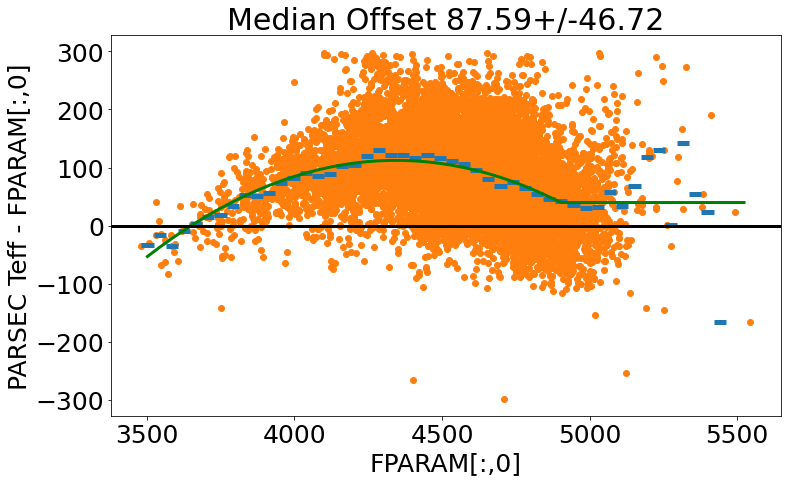

In [52]:
def teff_teff_corr(x,tbreak,dteff0,a,b):
    return np.piecewise(x,[x>tbreak],[lambda x: dteff0,lambda x: a*x**2+b*x+dteff0-a*tbreak**2-b*tbreak])

popt_teff_corr,_ = curve_fit(teff_teff_corr,teffcens[:teff_right],teffmeds[:teff_right],
                             p0=(5000,44.78470,-0.00023,2.00221))

param_labels = np.array(['tbreak','dteff0','a','b'])
print('Fit Parameters:')
for i in range(len(param_labels)):
    print(r'{} = {:.5f}'.format(param_labels[i],popt_teff_corr[i]))
    
plt.figure(figsize=[12,7])
plt.scatter(rgb[low_ak]['FPARAM'][:,0][fincut],(photteff['PHOTTEFF']-rgb[low_ak]['FPARAM'][:,0])[fincut],
            c='tab:orange')
plt.hlines(teffmeds, teffedgs[:-1], teffedgs[1:], colors='tab:blue', lw=5.)
plt.plot(teffcens,teff_teff_corr(teffcens,*popt_teff_corr),c='green',lw=3.0)
plt.axhline(0.0,c='k',lw=3.0)
plt.xlabel(r'FPARAM[:,0]')
plt.ylabel(r'PARSEC Teff - FPARAM[:,0]')
plt.title(r'Median Offset {:.2f}+/-{:.2f}'.format(np.median((photteff['PHOTTEFF']-rgb[low_ak]['FPARAM'][:,0])[fincut]),
                                                  mad((photteff['PHOTTEFF']-rgb[low_ak]['FPARAM'][:,0])[fincut])))
plt.show()

Fit Parameters:
a = 0.00719
b = 28.67253
Fit Parameters:
a = -0.05378
b = 333.19579


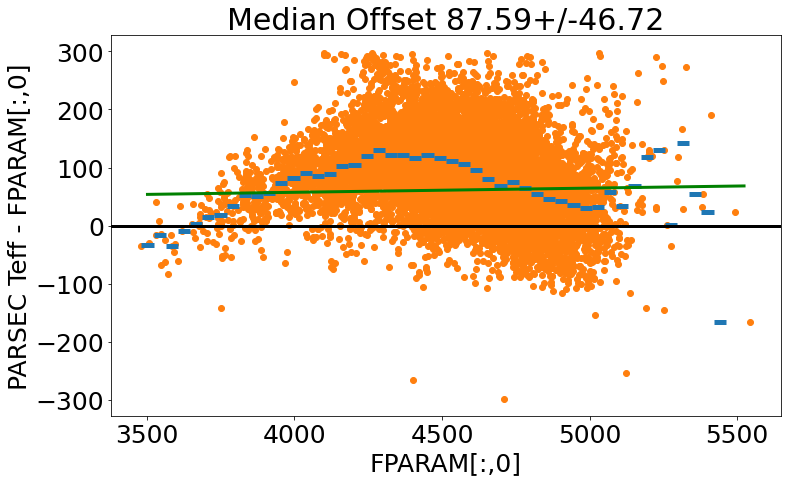

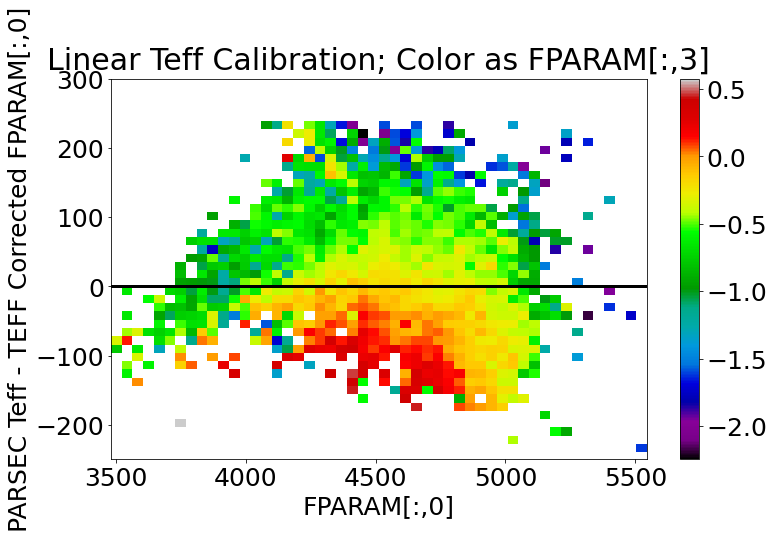

26.569074849502613
47.110841457042625


In [133]:
def teff_teff_corr2(x,a,b):
    return a*x+b

# popt_teff_corr2,_ = curve_fit(teff_teff_corr2,teffcens[:teff_right],teffmeds[:teff_right])
popt_teff_corr2,_ = curve_fit(teff_teff_corr2,teffcens,teffmeds)

# popt_teff_corr2a,_ = curve_fit(teff_teff_corr2,rgb[low_ak]['FPARAM'][:,0][fincut],
#                                (photteff['PHOTTEFF']-rgb[low_ak]['FPARAM'][:,0])[fincut])

param_labels = np.array(['a','b'])
print('Fit Parameters:')
for i in range(len(param_labels)):
    print(r'{} = {:.5f}'.format(param_labels[i],popt_teff_corr2[i]))
    
# print('Fit Parameters:')
# for i in range(len(param_labels)):
#     print(r'{} = {:.5f}'.format(param_labels[i],popt_teff_corr2a[i]))

###    
plt.figure(figsize=[12,7])
plt.scatter(rgb[low_ak]['FPARAM'][:,0][fincut],(photteff['PHOTTEFF']-rgb[low_ak]['FPARAM'][:,0])[fincut],
            c='tab:orange')
plt.hlines(teffmeds, teffedgs[:-1], teffedgs[1:], colors='tab:blue', lw=5.)
plt.plot(teffcens,teff_teff_corr2(teffcens,*popt_teff_corr2),c='green',lw=3.0)
# plt.plot(teffcens,teff_teff_corr2(teffcens,*popt_teff_corr2a),c='red',lw=3.0)
plt.axhline(0.0,c='k',lw=3.0)
plt.xlabel(r'FPARAM[:,0]')
plt.ylabel(r'PARSEC Teff - FPARAM[:,0]')
plt.title(r'Median Offset {:.2f}+/-{:.2f}'.format(np.median((photteff['PHOTTEFF']-rgb[low_ak]['FPARAM'][:,0])[fincut]),
                                                  mad((photteff['PHOTTEFF']-rgb[low_ak]['FPARAM'][:,0])[fincut])))
plt.show()

###
ret = binned_statistic_2d(rgb[low_ak]['FPARAM'][:,0][fincut],
            (photteff['PHOTTEFF']-(rgb[low_ak]['FPARAM'][:,0]+teff_teff_corr2(rgb[low_ak]['FPARAM'][:,0],*popt_teff_corr2)))[fincut],
                          rgb[low_ak]['FPARAM'][:,3][fincut],statistic='median',bins=50)

ret.statistic[ret.statistic == 0.0] = np.nan

plt.figure(figsize=[12,7])
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='nipy_spectral')

plt.colorbar()
plt.axhline(0.0,c='k',lw=3.0)
plt.title(r'Linear Teff Calibration; Color as FPARAM[:,3]',y=1.01)
plt.xlabel(r'FPARAM[:,0]')
plt.ylabel(r'PARSEC Teff - TEFF Corrected FPARAM[:,0]')
plt.ylim(-250,300)
plt.show()

print(np.median((photteff['PHOTTEFF']-(rgb[low_ak]['FPARAM'][:,0]+teff_teff_corr2(rgb[low_ak]['FPARAM'][:,0],*popt_teff_corr2)))[fincut]))
print(mad((photteff['PHOTTEFF']-(rgb[low_ak]['FPARAM'][:,0]+teff_teff_corr2(rgb[low_ak]['FPARAM'][:,0],*popt_teff_corr2)))[fincut]))

# Calculate the [M/H] dependent calibration for FPARAM[:,0] 

In [127]:
mhmeds,mhedgs,mhnums = binned_statistic(rgb[low_ak]['FPARAM'][:,3][fincut],
            (photteff['PHOTTEFF']-(rgb[low_ak]['FPARAM'][:,0]+teff_teff_corr2(rgb[low_ak]['FPARAM'][:,0],*popt_teff_corr2)))[fincut],
                               statistic='median',bins=50)
mhcens = mhedgs[:-1]+np.median(np.diff(mhedgs))/2.

mhcens=mhcens[np.where(np.isfinite(mhmeds)==True)]
mhmeds=mhmeds[np.where(np.isfinite(mhmeds)==True)]

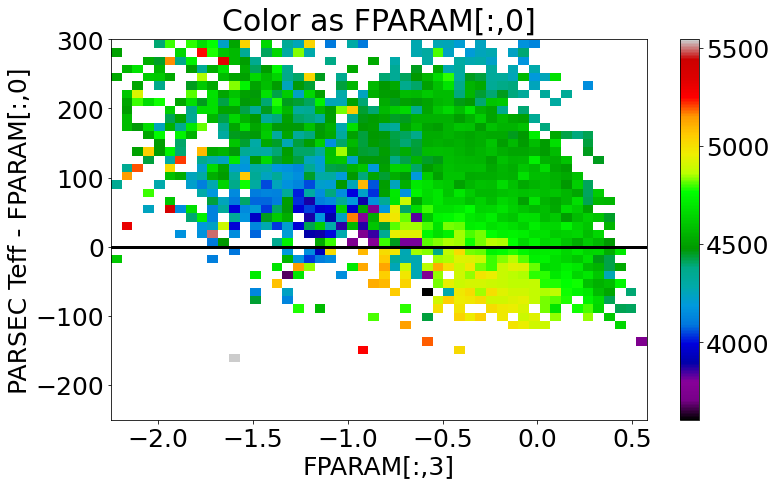

87.5938975975896
46.72280532959667


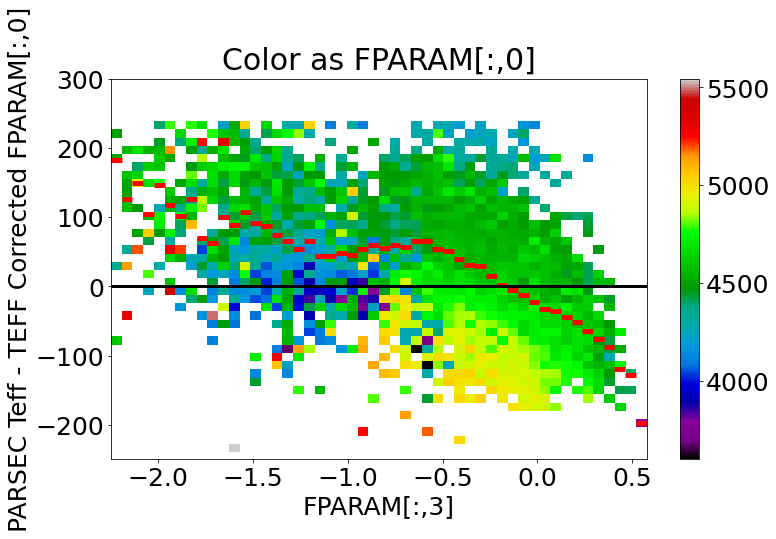

26.569074849502613
47.110841457042625


In [156]:
###
ret = binned_statistic_2d(rgb[low_ak]['FPARAM'][:,3][fincut],
            (photteff['PHOTTEFF']-(rgb[low_ak]['FPARAM'][:,0]))[fincut],
                          rgb[low_ak]['FPARAM'][:,0][fincut],statistic='median',bins=50)

ret.statistic[ret.statistic == 0.0] = np.nan

plt.figure(figsize=[12,7])
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='nipy_spectral')

plt.colorbar()
plt.axhline(0.0,c='k',lw=3.0)
plt.title(r'Color as FPARAM[:,0]',y=1.01)
plt.xlabel(r'FPARAM[:,3]')
plt.ylabel(r'PARSEC Teff - FPARAM[:,0]')
plt.ylim(-250,300)
plt.show()

print(np.median((photteff['PHOTTEFF']-(rgb[low_ak]['FPARAM'][:,0]))[fincut]))
print(mad((photteff['PHOTTEFF']-(rgb[low_ak]['FPARAM'][:,0]))[fincut]))

###
mhmeds,mhedgs,mhnums = binned_statistic(rgb[low_ak]['FPARAM'][:,3][fincut],
            (photteff['PHOTTEFF']-(rgb[low_ak]['FPARAM'][:,0]+teff_teff_corr2(rgb[low_ak]['FPARAM'][:,0],*popt_teff_corr2)))[fincut],
                               statistic='median',bins=50)
mhcens = mhedgs[:-1]+np.median(np.diff(mhedgs))/2.

mhcens=mhcens[np.where(np.isfinite(mhmeds)==True)]
mhmeds=mhmeds[np.where(np.isfinite(mhmeds)==True)]


ret = binned_statistic_2d(rgb[low_ak]['FPARAM'][:,3][fincut],
            (photteff['PHOTTEFF']-(rgb[low_ak]['FPARAM'][:,0]+teff_teff_corr2(rgb[low_ak]['FPARAM'][:,0],*popt_teff_corr2)))[fincut],
                          rgb[low_ak]['FPARAM'][:,0][fincut],statistic='median',bins=50)

ret.statistic[ret.statistic == 0.0] = np.nan

plt.figure(figsize=[12,7])
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='nipy_spectral')

plt.colorbar()

plt.hlines(mhmeds, mhedgs[:-1], mhedgs[1:], colors='r', lw=5.)

plt.axhline(0.0,c='k',lw=3.0)
plt.title(r'Color as FPARAM[:,0]',y=1.01)
plt.xlabel(r'FPARAM[:,3]')
plt.ylabel(r'PARSEC Teff - TEFF Corrected FPARAM[:,0]')
plt.ylim(-250,300)
plt.show()

print(np.median((photteff['PHOTTEFF']-(rgb[low_ak]['FPARAM'][:,0]+teff_teff_corr2(rgb[low_ak]['FPARAM'][:,0],*popt_teff_corr2)))[fincut]))
print(mad((photteff['PHOTTEFF']-(rgb[low_ak]['FPARAM'][:,0]+teff_teff_corr2(rgb[low_ak]['FPARAM'][:,0],*popt_teff_corr2)))[fincut]))

In [134]:
def teff_feh_corr2(x,a,b):
    return a*x+b

popt_feh_corr2,_ = curve_fit(teff_feh_corr2,mhcens,mhmeds)

param_labels = np.array(['a','b'])
print('Fit Parameters:')
for i in range(len(param_labels)):
    print(r'{} = {:.5f}'.format(param_labels[i],popt_feh_corr2[i]))

Fit Parameters:
mh0 = -72.58476
a = -6.49738


IndexError: index 2 is out of bounds for axis 0 with size 2

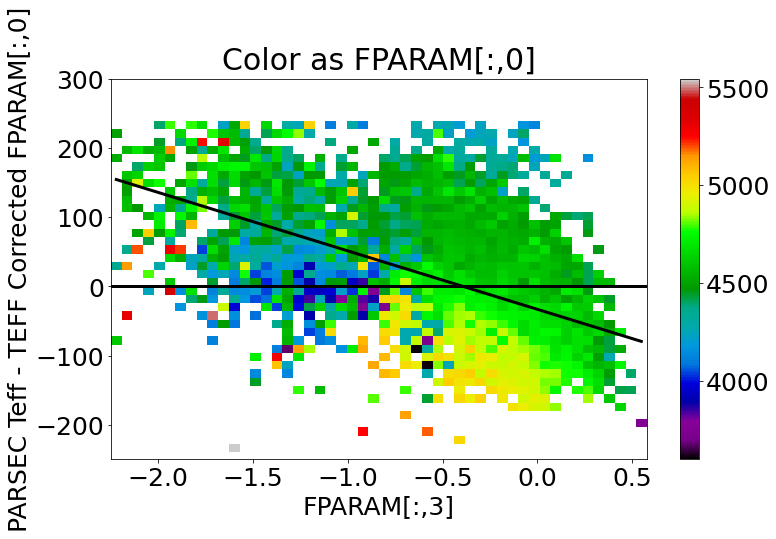

In [129]:
ret = binned_statistic_2d(rgb[low_ak]['FPARAM'][:,3][fincut],
            (photteff['PHOTTEFF']-(rgb[low_ak]['FPARAM'][:,0]+teff_teff_corr2(rgb[low_ak]['FPARAM'][:,0],*popt_teff_corr2)))[fincut],
                          rgb[low_ak]['FPARAM'][:,0][fincut],statistic='median',bins=50)

ret.statistic[ret.statistic == 0.0] = np.nan

plt.figure(figsize=[12,7])
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='nipy_spectral')

plt.colorbar()

plt.plot(mhcens,teff_feh_corr2(mhcens,*popt_feh_corr2),c='k',lw=3.0)

plt.axhline(0.0,c='k',lw=3.0)
plt.title(r'Color as FPARAM[:,0]',y=1.01)
plt.xlabel(r'FPARAM[:,3]')
plt.ylabel(r'PARSEC Teff - TEFF Corrected FPARAM[:,0]')
plt.ylim(-250,300)
plt.show()

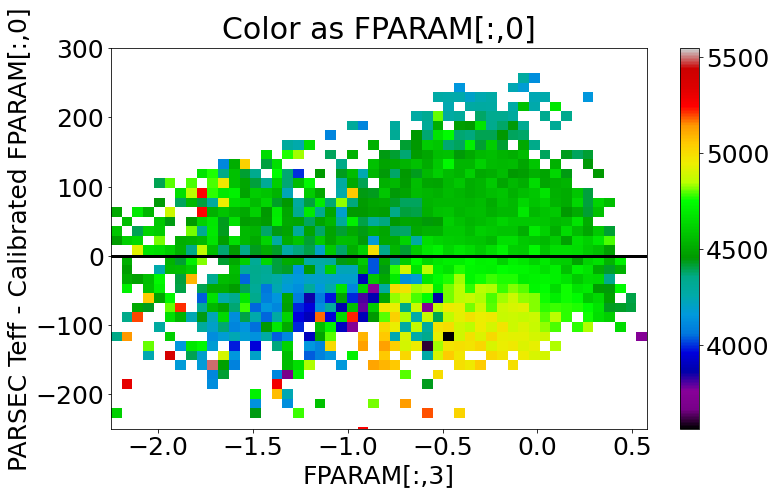

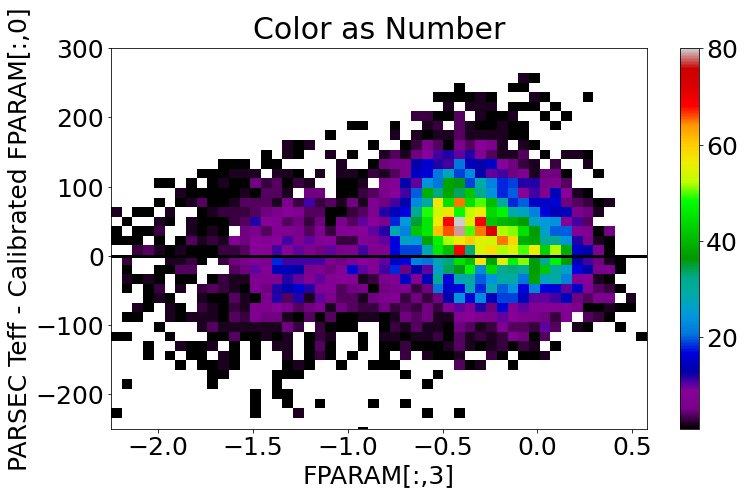

21.87043827123307
39.40869648187709


In [132]:
ret = binned_statistic_2d(rgb[low_ak]['FPARAM'][:,3][fincut],
            (photteff['PHOTTEFF']-(rgb[low_ak]['FPARAM'][:,0]+teff_teff_corr2(rgb[low_ak]['FPARAM'][:,0],*popt_teff_corr2)+teff_feh_corr2(rgb[low_ak]['FPARAM'][:,3],*popt_feh_corr2)))[fincut],
                          rgb[low_ak]['FPARAM'][:,0][fincut],statistic='median',bins=50)

ret.statistic[ret.statistic == 0.0] = np.nan

plt.figure(figsize=[12,7])
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='nipy_spectral')

plt.colorbar()

# plt.plot(mhcens,teff_feh_corr2(mhcens,*popt_feh_corr2),c='k',lw=3.0)

plt.axhline(0.0,c='k',lw=3.0)
plt.title(r'Color as FPARAM[:,0]',y=1.01)
plt.xlabel(r'FPARAM[:,3]')
plt.ylabel(r'PARSEC Teff - Calibrated FPARAM[:,0]')
plt.ylim(-250,300)
plt.show()

###
ret = binned_statistic_2d(rgb[low_ak]['FPARAM'][:,3][fincut],
            (photteff['PHOTTEFF']-(rgb[low_ak]['FPARAM'][:,0]+teff_teff_corr2(rgb[low_ak]['FPARAM'][:,0],*popt_teff_corr2)+teff_feh_corr2(rgb[low_ak]['FPARAM'][:,3],*popt_feh_corr2)))[fincut],
                          rgb[low_ak]['FPARAM'][:,3][fincut],statistic='count',bins=50)

ret.statistic[ret.statistic == 0.0] = np.nan

plt.figure(figsize=[12,7])
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='nipy_spectral')

plt.colorbar()

# plt.plot(mhcens,teff_feh_corr2(mhcens,*popt_feh_corr2),c='k',lw=3.0)

plt.axhline(0.0,c='k',lw=3.0)
plt.title(r'Color as Number',y=1.01)
plt.xlabel(r'FPARAM[:,3]')
plt.ylabel(r'PARSEC Teff - Calibrated FPARAM[:,0]')
plt.ylim(-250,300)
plt.show()

print(np.median((photteff['PHOTTEFF']-(rgb[low_ak]['FPARAM'][:,0]+teff_teff_corr2(rgb[low_ak]['FPARAM'][:,0],*popt_teff_corr2)+teff_feh_corr2(rgb[low_ak]['FPARAM'][:,3],*popt_feh_corr2)))[fincut]))
print(mad((photteff['PHOTTEFF']-(rgb[low_ak]['FPARAM'][:,0]+teff_teff_corr2(rgb[low_ak]['FPARAM'][:,0],*popt_teff_corr2)+teff_feh_corr2(rgb[low_ak]['FPARAM'][:,3],*popt_feh_corr2)))[fincut]))

In [141]:
def teff_feh_corr2a(x,a,b,c,d):
    '''
    mh0: break 
    '''
    
    def metalrich(x,a,b):
        return a*x+b
    def metalpoor(x,c,d):
        return c*x+d
    
    return np.piecewise(x,[x<-1.],[lambda x: metalpoor(x,a,b), lambda x: metalrich(x,c,d)])

popt_feh_corr2a,_ = curve_fit(teff_feh_corr2a,rgb[low_ak]['FPARAM'][:,3][fincut],
            (photteff['PHOTTEFF']-(rgb[low_ak]['FPARAM'][:,0]+teff_teff_corr2(rgb[low_ak]['FPARAM'][:,0],*popt_teff_corr2)))[fincut])

param_labels = np.array(['a','b','c','d'])
print('Fit Parameters:')
for i in range(len(param_labels)):
    print(r'{} = {:.5f}'.format(param_labels[i],popt_feh_corr2a[i]))

Fit Parameters:
a = -69.91728
b = -23.65939
c = -118.33009
d = -17.27339


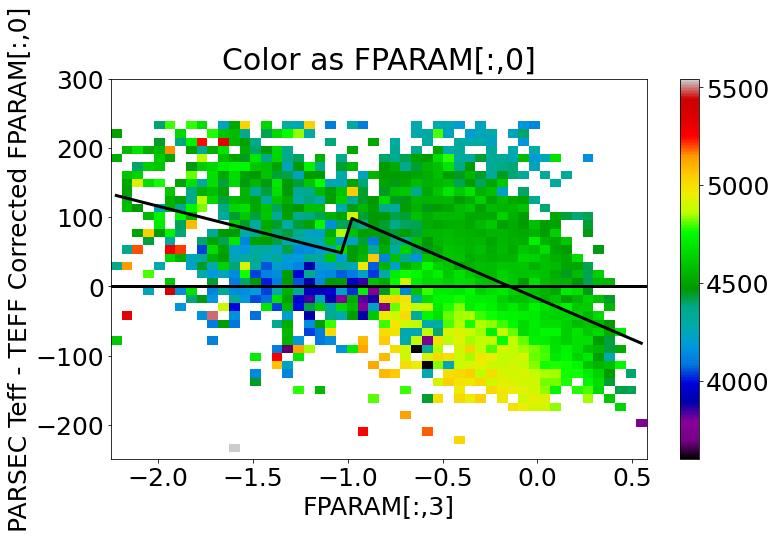

In [142]:
ret = binned_statistic_2d(rgb[low_ak]['FPARAM'][:,3][fincut],
            (photteff['PHOTTEFF']-(rgb[low_ak]['FPARAM'][:,0]+teff_teff_corr2(rgb[low_ak]['FPARAM'][:,0],*popt_teff_corr2)))[fincut],
                          rgb[low_ak]['FPARAM'][:,0][fincut],statistic='median',bins=50)

ret.statistic[ret.statistic == 0.0] = np.nan

plt.figure(figsize=[12,7])
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='nipy_spectral')

plt.colorbar()

plt.plot(mhcens,teff_feh_corr2a(mhcens,*popt_feh_corr2a),c='k',lw=3.0)

plt.axhline(0.0,c='k',lw=3.0)
plt.title(r'Color as FPARAM[:,0]',y=1.01)
plt.xlabel(r'FPARAM[:,3]')
plt.ylabel(r'PARSEC Teff - TEFF Corrected FPARAM[:,0]')
plt.ylim(-250,300)
plt.show()

In [ ]:
# def quintic_spline(dx, dtype=np.float64):
#     def inner(x):
#         return 1 + x ** 3 / 12 * (-95 + 138 * x - 55 * x ** 2)

#     def middle(x):
#         return (x - 1) * (x - 2) / 24 * (-138 + 348 * x - 249 * x ** 2 + 55 * x ** 3)

#     def outer(x):
#         return (x - 2) * (x - 3) ** 2 / 24 * (-54 + 50 * x - 11 * x ** 2)

#     window = np.arange(-3, 4)
#     x = np.abs(dx - window)
#     result = np.piecewise(
#         x,
#         [x <= 1, (x > 1) & (x <= 2), (x > 2) & (x <= 3)],
#         [lambda x: inner(x), lambda x: middle(x), lambda x: outer(x)],
#     )
#     return result, window 

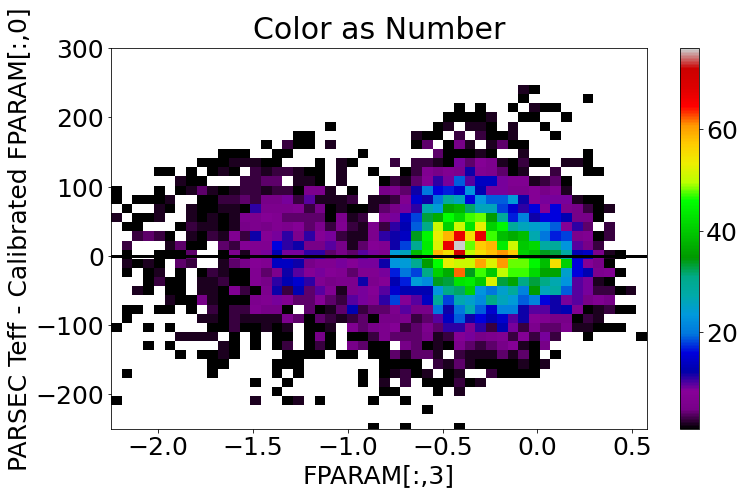

0.20916124051382212
37.34078312129077


In [144]:
ret = binned_statistic_2d(rgb[low_ak]['FPARAM'][:,3][fincut],
            (photteff['PHOTTEFF']-(rgb[low_ak]['FPARAM'][:,0]+teff_teff_corr2(rgb[low_ak]['FPARAM'][:,0],*popt_teff_corr2)+teff_feh_corr2a(rgb[low_ak]['FPARAM'][:,3],*popt_feh_corr2a)))[fincut],
                          rgb[low_ak]['FPARAM'][:,3][fincut],statistic='count',bins=50)

ret.statistic[ret.statistic == 0.0] = np.nan

plt.figure(figsize=[12,7])
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='nipy_spectral')

plt.colorbar()

# plt.plot(mhcens,teff_feh_corr2a(mhcens,*popt_feh_corr2),c='k',lw=3.0)

plt.axhline(0.0,c='k',lw=3.0)
plt.title(r'Color as Number',y=1.01)
plt.xlabel(r'FPARAM[:,3]')
plt.ylabel(r'PARSEC Teff - Calibrated FPARAM[:,0]')
plt.ylim(-250,300)
plt.show()

print(np.median((photteff['PHOTTEFF']-(rgb[low_ak]['FPARAM'][:,0]+teff_teff_corr2(rgb[low_ak]['FPARAM'][:,0],*popt_teff_corr2)+teff_feh_corr2a(rgb[low_ak]['FPARAM'][:,3],*popt_feh_corr2a)))[fincut]))
print(mad((photteff['PHOTTEFF']-(rgb[low_ak]['FPARAM'][:,0]+teff_teff_corr2(rgb[low_ak]['FPARAM'][:,0],*popt_teff_corr2)+teff_feh_corr2a(rgb[low_ak]['FPARAM'][:,3],*popt_feh_corr2a)))[fincut]))

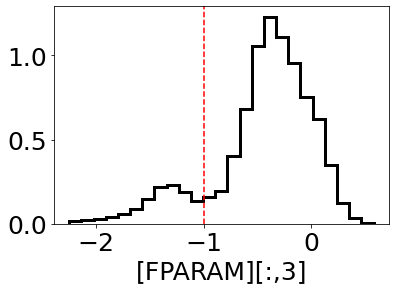

In [150]:
plt.hist(rgb[low_ak]['FPARAM'][:,3][fincut],density=True,histtype='step',color='k',lw=3.0,bins=25)
plt.axvline(-1.0,c='r',ls='--')
plt.xlabel(r'[FPARAM][:,3]');

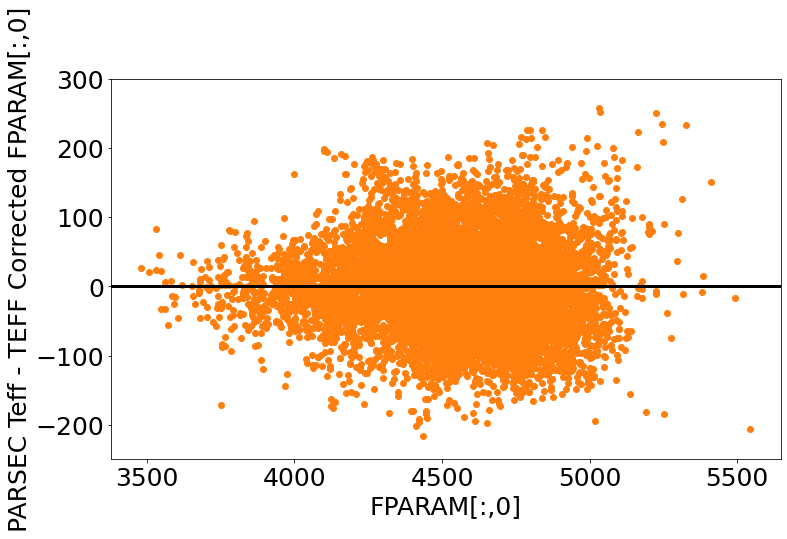

0.9094946773375341
41.39065348880467


In [59]:
plt.figure(figsize=[12,7])
plt.scatter(rgb[low_ak]['FPARAM'][:,0][fincut],
            (photteff['PHOTTEFF']-(rgb[low_ak]['FPARAM'][:,0]+teff_teff_corr(rgb[low_ak]['FPARAM'][:,0],*popt_teff_corr)))[fincut],
            c='tab:orange')

plt.axhline(0.0,c='k',lw=3.0)
plt.xlabel(r'FPARAM[:,0]')
plt.ylabel(r'PARSEC Teff - TEFF Corrected FPARAM[:,0]')
plt.ylim(-250,300)
plt.show()

print(np.median((photteff['PHOTTEFF']-(rgb[low_ak]['FPARAM'][:,0]+teff_teff_corr(rgb[low_ak]['FPARAM'][:,0],*popt_teff_corr)))[fincut]))
print(mad((photteff['PHOTTEFF']-(rgb[low_ak]['FPARAM'][:,0]+teff_teff_corr(rgb[low_ak]['FPARAM'][:,0],*popt_teff_corr)))[fincut]))

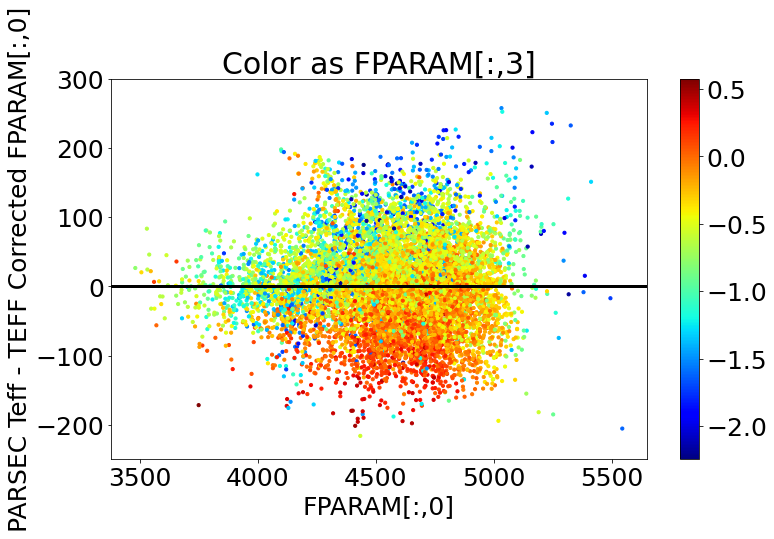

In [65]:
plt.figure(figsize=[12,7])
plt.scatter(rgb[low_ak]['FPARAM'][:,0][fincut],
            (photteff['PHOTTEFF']-(rgb[low_ak]['FPARAM'][:,0]+teff_teff_corr(rgb[low_ak]['FPARAM'][:,0],*popt_teff_corr)))[fincut],
            c=rgb[low_ak]['FPARAM'][:,3][fincut],cmap='jet',s=10)
plt.colorbar()
plt.axhline(0.0,c='k',lw=3.0)
plt.title(r'Color as FPARAM[:,3]')
plt.xlabel(r'FPARAM[:,0]')
plt.ylabel(r'PARSEC Teff - TEFF Corrected FPARAM[:,0]')
plt.ylim(-250,300)
plt.show()

ZeroDivisionError: division by zero

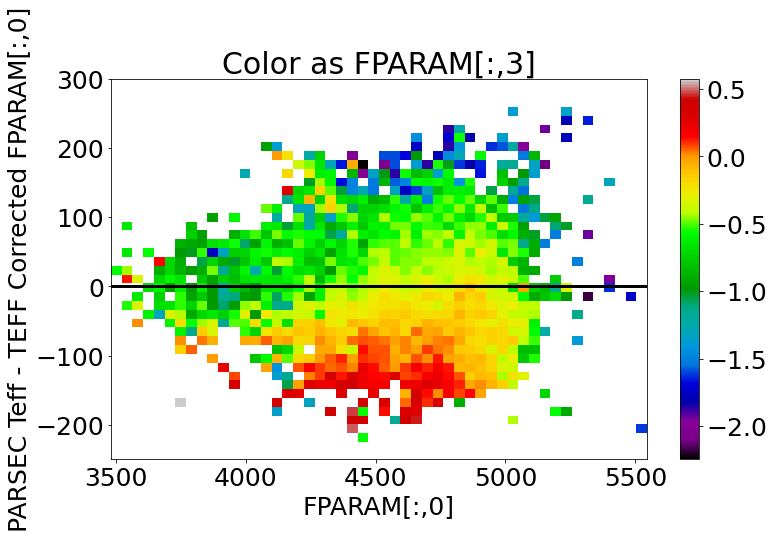

In [73]:
ret = binned_statistic_2d(rgb[low_ak]['FPARAM'][:,0][fincut],
            (photteff['PHOTTEFF']-(rgb[low_ak]['FPARAM'][:,0]+teff_teff_corr(rgb[low_ak]['FPARAM'][:,0],*popt_teff_corr)))[fincut],
            rgb[low_ak]['FPARAM'][:,3][fincut],'median',bins=50)

ret.statistic[ret.statistic == 0.0] = np.nan

plt.figure(figsize=[12,7])
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='nipy_spectral')

plt.colorbar()
plt.axhline(0.0,c='k',lw=3.0)
plt.title(r'Color as FPARAM[:,3]')
plt.xlabel(r'FPARAM[:,0]')
plt.ylabel(r'PARSEC Teff - TEFF Corrected FPARAM[:,0]')
plt.ylim(-250,300)
plt.show()

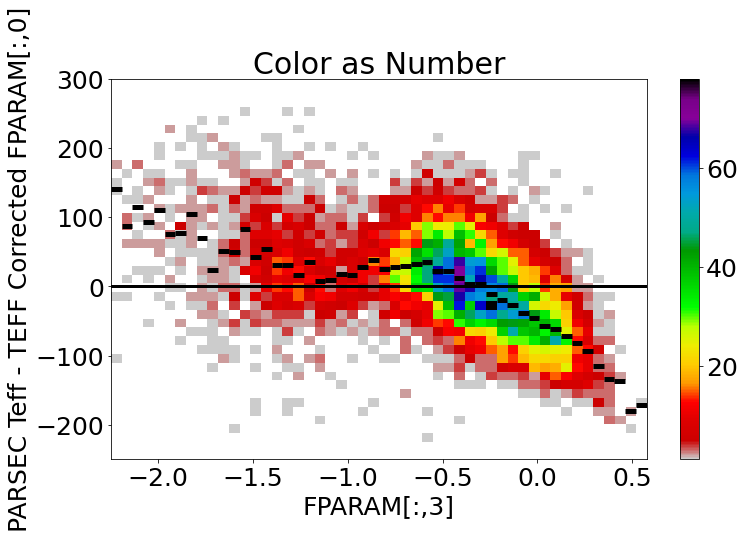

In [97]:
mhmeds,mhedgs,mhnums = binned_statistic(rgb[low_ak]['FPARAM'][:,3][fincut],
            (photteff['PHOTTEFF']-(rgb[low_ak]['FPARAM'][:,0]+teff_teff_corr(rgb[low_ak]['FPARAM'][:,0],*popt_teff_corr)))[fincut],
                               statistic='median',bins=50)
mhcens = mhedgs[:-1]+np.median(np.diff(mhedgs))/2.

mhcens=mhcens[np.where(np.isfinite(mhmeds)==True)]
mhmeds=mhmeds[np.where(np.isfinite(mhmeds)==True)]



ret = binned_statistic_2d(rgb[low_ak]['FPARAM'][:,3][fincut],
            (photteff['PHOTTEFF']-(rgb[low_ak]['FPARAM'][:,0]+teff_teff_corr(rgb[low_ak]['FPARAM'][:,0],*popt_teff_corr)))[fincut],
            rgb[low_ak]['FPARAM'][:,3][fincut],'count',bins=50)

ret.statistic[ret.statistic == 0.0] = np.nan

plt.figure(figsize=[12,7])
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='nipy_spectral_r')

plt.colorbar()

plt.hlines(mhmeds, mhedgs[:-1], mhedgs[1:], colors='k', lw=5.)

plt.axhline(0.0,c='k',lw=3.0)
# plt.axvline(-1.0,c='tab:blue',lw=3.0)
plt.title(r'Color as Number')
plt.xlabel(r'FPARAM[:,3]')
plt.ylabel(r'PARSEC Teff - TEFF Corrected FPARAM[:,0]')
plt.ylim(-250,300)
plt.show()

In [93]:
def teff_mh_corr(x,a,b,c,d):
    mh0 = -1.0
    mh1 = -0.5
    def mp(x):
        mh0 = -1.0
        mh1 = -0.5
        return a*x+b

    def mi(x):
        mh0 = -1.0
        mh1 = -0.5
        return c*x+(a-c)*mh0

    def mr(x):
        mh0 = -1.0
        mh1 = -0.5
        return d*x+(c-d)*mh1+(a-c)*mh0

    result = np.piecewise(
        x,
        [(x < mh0), (x >= mh0) & (x < mh1), (mh1 <= x)],
        [lambda x: mp(x), lambda x: mi(x), lambda x: mr(x)],
    )
    return result

popt_mh_corr,_ = curve_fit(teff_mh_corr,mhcens,mhmeds,p0=(-1.0,100.0,1.0,-1.0))

param_labels = np.array(['a','b','c','d'])
print('Fit Parameters:')
for i in range(len(param_labels)):
    print(r'{} = {:.5f}'.format(param_labels[i],popt_mh_corr[i]))

Fit Parameters:
a = -57.80937
b = -33.74878
c = -55.17510
d = -177.90442


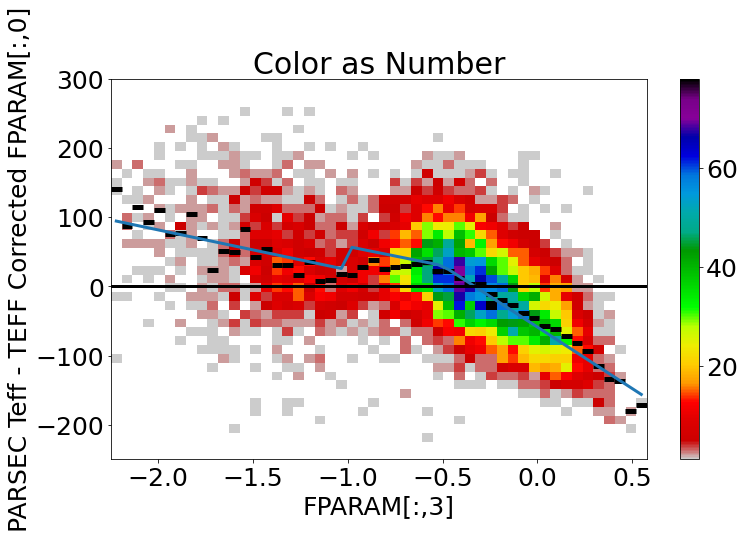

In [96]:
plt.figure(figsize=[12,7])
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='nipy_spectral_r')

plt.colorbar()

# xs_fparam3 = np.linspace(np.nanmin(rgb[low_ak]['FPARAM'][:,3][fincut]),np.nanmax(rgb[low_ak]['FPARAM'][:,3][fincut]))

plt.hlines(mhmeds, mhedgs[:-1], mhedgs[1:], colors='k', lw=5.)

plt.plot(mhcens,teff_mh_corr(mhcens,*popt_mh_corr),lw=3.0)

plt.axhline(0.0,c='k',lw=3.0)
# plt.axvline(-1.0,c='tab:blue',lw=3.0)
plt.title(r'Color as Number')
plt.xlabel(r'FPARAM[:,3]')
plt.ylabel(r'PARSEC Teff - TEFF Corrected FPARAM[:,0]')
plt.ylim(-250,300)
plt.show()

In [91]:
def teff_feh_corr(x,tbreak,dteff0,a,b):
    return np.piecewise(x,[x>tbreak],[lambda x: dteff0,lambda x: a*x**2+b*x+dteff0-a*tbreak**2-b*tbreak])

popt_teff_corr,_ = curve_fit(teff_teff_corr,teffcens[:teff_right],teffmeds[:teff_right],
                             p0=(5000,44.78470,-0.00023,2.00221))

param_labels = np.array(['tbreak','dteff0','a','b'])
print('Fit Parameters:')
for i in range(len(param_labels)):
    print(r'{} = {:.5f}'.format(param_labels[i],popt_teff_corr[i]))

Fit Parameters:
tbreak = 4901.96072
dteff0 = 39.81938
a = -0.00023
b = 2.02541


In [28]:
# fincut = np.where((np.isfinite(rgb[low_ak]['FPARAM'][:,0])==True)&(np.isfinite(photteff)==True)&
#                   (np.isfinite(rgb_salfeh[low_ak])==True)&(photteff-rgb[low_ak]['FPARAM'][:,0]>-300)&
#                   (photteff-rgb[low_ak]['FPARAM'][:,0]<300))

# plt.figure(figsize=[12,7])

# meds,edgs,_ = binned_statistic(rgb[low_ak]['FPARAM'][:,0][fincut],(photteff-rgb[low_ak]['FPARAM'][:,0])[fincut],
#                                bins=50)
# cens = edgs[:-1]+np.median(np.diff(edgs))/2.0

# plt.scatter(rgb[low_ak]['FPARAM'][:,0][fincut],(photteff-rgb[low_ak]['FPARAM'][:,0])[fincut])

# plt.hlines(meds, edgs[:-1], edgs[1:], colors='r', lw=5.)

# plt.axhline(0.,c='k',lw=3.)
# plt.ylim(-200,300)

# plt.title(r'Color as Number')
# plt.xlabel(r'FPARAM[:,0]')
# plt.ylabel(r'PARSEC Teff - FPARAM[:,0]');

Fit Parameters:
tbreak = 4887.22534
dteff0 = 45.42567
a = -0.00023
b = 2.03726


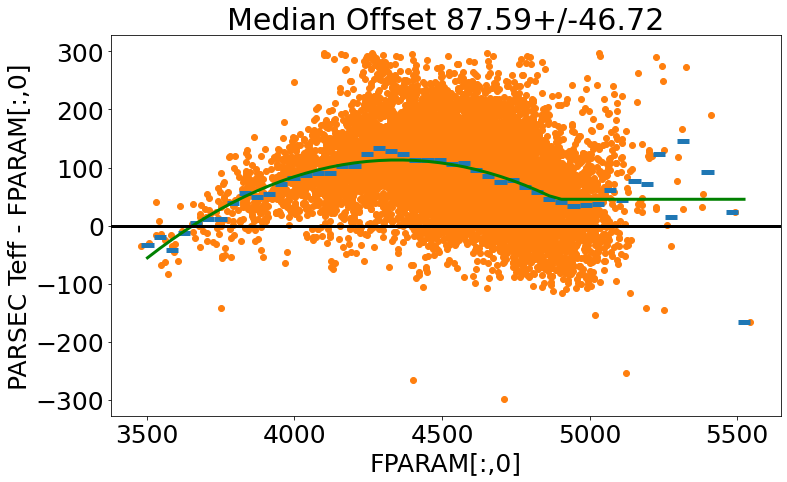

In [224]:
fincut = np.where((np.isfinite(rgb[low_ak]['FPARAM'][:,0])==True)&(np.isfinite(photteff)==True)&
                  (np.isfinite(rgb_salfeh[low_ak])==True)&(photteff-rgb[low_ak]['FPARAM'][:,0]>-300)&
                  (photteff-rgb[low_ak]['FPARAM'][:,0]<300))

plt.figure(figsize=[12,7])

meds,edgs,_ = binned_statistic(rgb[low_ak]['FPARAM'][:,0][fincut],(photteff-rgb[low_ak]['FPARAM'][:,0])[fincut],
                               bins=50)
cens = edgs[:-1]+np.median(np.diff(edgs))/2.0

fincut2 = np.where((np.isfinite(cens)==True)&(np.isfinite(meds)==True))

def teff_cal(x,tbreak,dteff0,a,b):
#     tbreak = 4900
    return np.piecewise(x,[x>tbreak],[lambda x: dteff0,lambda x: a*x**2+b*x+dteff0-a*tbreak**2-b*tbreak])

popt , _ = curve_fit(teff_cal,cens[fincut2],meds[fincut2],p0=(4900,44.78470,-0.00023,2.00221))

param_labels = np.array(['tbreak','dteff0','a','b'])
print('Fit Parameters:')
for i in range(len(param_labels)):
    print(r'{} = {:.5f}'.format(param_labels[i],popt[i]))

plt.scatter(rgb[low_ak]['FPARAM'][:,0][fincut],(photteff-rgb[low_ak]['FPARAM'][:,0])[fincut],c='tab:orange')
plt.hlines(meds, edgs[:-1], edgs[1:], colors='tab:blue', lw=5.)
plt.plot(cens,teff_cal(cens,*popt),c='green',lw=3.0)
plt.axhline(0.0,c='k',lw=3.0)
plt.xlabel(r'FPARAM[:,0]')
plt.ylabel(r'PARSEC Teff - FPARAM[:,0]')
plt.title(r'Median Offset {:.2f}+/-{:.2f}'.format(np.median((photteff-rgb[low_ak]['FPARAM'][:,0])[fincut]),
                                                  mad((photteff-rgb[low_ak]['FPARAM'][:,0])[fincut])))
plt.show()

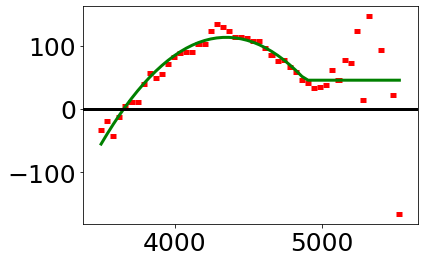

In [217]:
# plt.scatter(rgb[low_ak]['FPARAM'][:,0][fincut],(photteff-rgb[low_ak]['FPARAM'][:,0])[fincut])
plt.hlines(meds, edgs[:-1], edgs[1:], colors='r', lw=5.)
plt.plot(cens,teff_cal(cens,*popt),c='green',lw=3.0)
plt.axhline(0.0,c='k',lw=3.0)
plt.show()

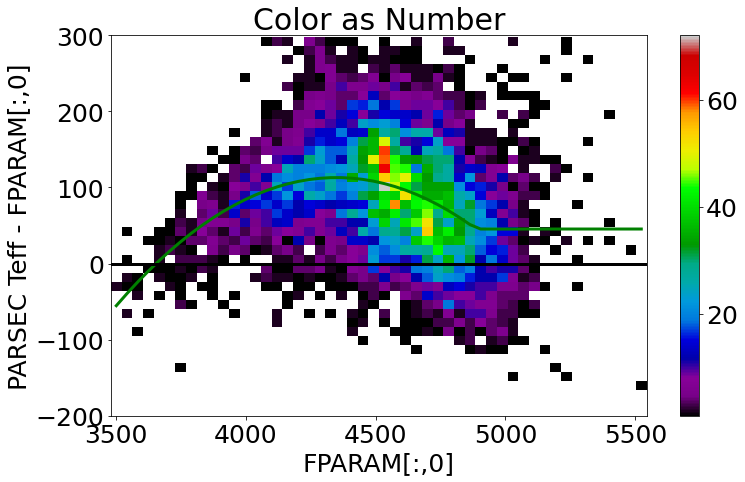

In [214]:
fincut = np.where((np.isfinite(rgb[low_ak]['FPARAM'][:,0])==True)&(np.isfinite(photteff)==True)&
                  (np.isfinite(rgb_salfeh[low_ak])==True)&(photteff-rgb[low_ak]['FPARAM'][:,0]>-300)&
                  (photteff-rgb[low_ak]['FPARAM'][:,0]<300))

plt.figure(figsize=[12,7])

meds,edgs,_ = binned_statistic(rgb[low_ak]['FPARAM'][:,0][fincut],(photteff-rgb[low_ak]['FPARAM'][:,0])[fincut],
                               bins=50)

ret = binned_statistic_2d(rgb[low_ak]['FPARAM'][:,0][fincut],(photteff-rgb[low_ak]['FPARAM'][:,0])[fincut],
                          rgb[low_ak]['FPARAM'][:,0][fincut],'count',bins=50)

ret.statistic[ret.statistic == 0.0] = np.nan

im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='nipy_spectral')

plt.colorbar()

plt.plot(cens,teff_cal(cens,*popt),c='green',lw=3.0)

plt.axhline(0.,c='k',lw=3.)
plt.ylim(-200,300)

plt.title(r'Color as Number')
plt.xlabel(r'FPARAM[:,0]')
plt.ylabel(r'PARSEC Teff - FPARAM[:,0]');

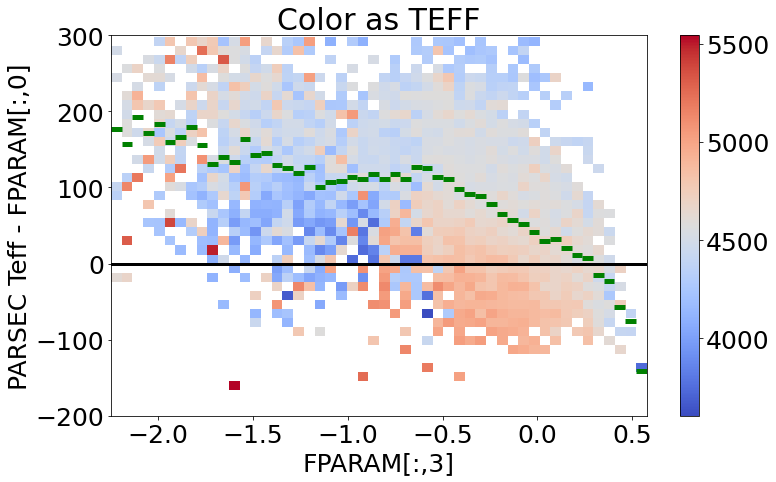

In [188]:
fincut = np.where((np.isfinite(rgb[low_ak]['FPARAM'][:,0])==True)&(np.isfinite(photteff)==True)&
                  (np.isfinite(rgb[low_ak]['FPARAM'][:,3])==True)&(photteff-rgb[low_ak]['FPARAM'][:,0]>-300)&
                  (photteff-rgb[low_ak]['FPARAM'][:,0]<300))

plt.figure(figsize=[12,7])

ret = binned_statistic_2d(rgb[low_ak]['FPARAM'][:,3][fincut],(photteff-rgb[low_ak]['FPARAM'][:,0])[fincut],
                          rgb[low_ak]['FPARAM'][:,0][fincut],'median',bins=50)

meds,edgs,_ = binned_statistic(rgb[low_ak]['FPARAM'][:,3][fincut],(photteff-rgb[low_ak]['FPARAM'][:,0])[fincut],
                               bins=50)

# # cens = edgs[:-1]+np.median(np.diff(edgs)/2)

# plt.scatter(rgb[low_ak]['FPARAM'][:,1][fincut],(photteff-rgb[low_ak]['FPARAM'][:,0])[fincut])
plt.hlines(meds, edgs[:-1], edgs[1:], colors='green', lw=5.)

ret.statistic[ret.statistic == 0.0] = np.nan

im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='coolwarm')

plt.colorbar()
plt.axhline(0.,c='k',lw=3.)
plt.ylim(-200,300)

plt.title(r'Color as TEFF')
plt.xlabel(r'FPARAM[:,3]')
plt.ylabel(r'PARSEC Teff - FPARAM[:,0]');

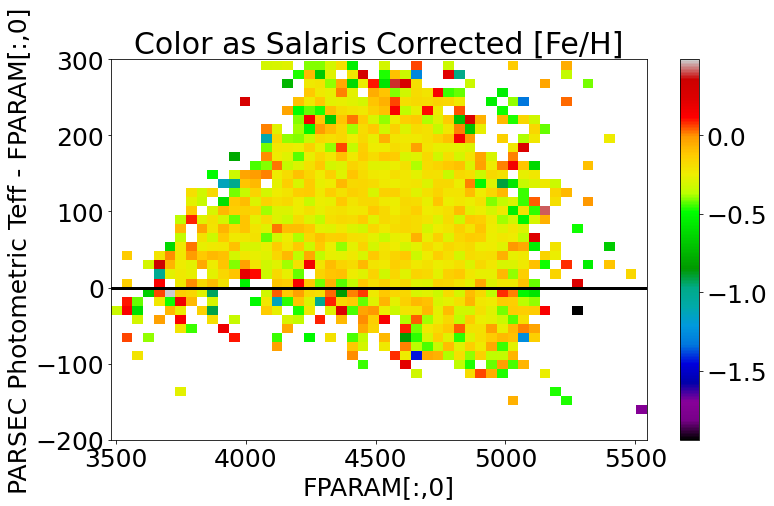

In [127]:
fincut = np.where((np.isfinite(rgb[low_ak]['FPARAM'][:,0])==True)&(np.isfinite(photteff)==True)&
                  (np.isfinite(rgb_salfeh[low_ak])==True)&(photteff-rgb[low_ak]['FPARAM'][:,0]>-300)&
                  (photteff-rgb[low_ak]['FPARAM'][:,0]<300))

plt.figure(figsize=[12,7])

ret = binned_statistic_2d(rgb[low_ak]['FPARAM'][:,0][fincut],(photteff-rgb[low_ak]['FPARAM'][:,0])[fincut],
                          rgb_salfeh[low_ak][fincut],'median',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='nipy_spectral')

plt.colorbar()
plt.axhline(0.,c='k',lw=3.)
plt.ylim(-200,300)

plt.title(r'Color as Salaris Corrected [Fe/H]')
plt.xlabel(r'FPARAM[:,0]')
plt.ylabel(r'PARSEC Photometric Teff - FPARAM[:,0]');

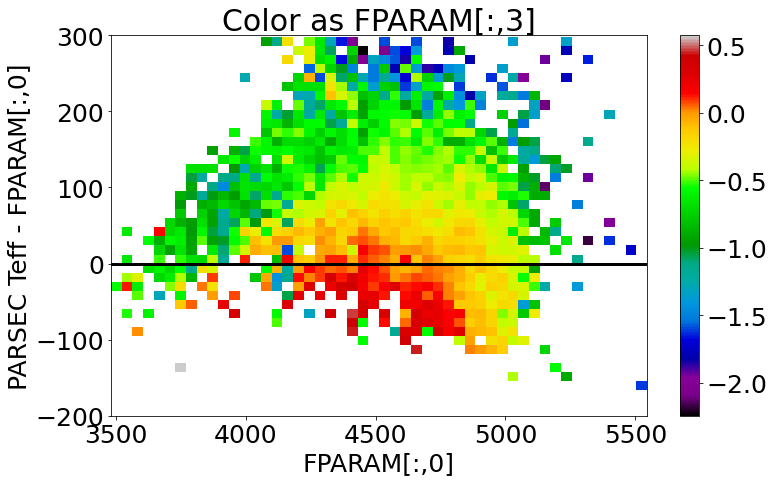

In [225]:
fincut = np.where((np.isfinite(rgb[low_ak]['FPARAM'][:,0])==True)&(np.isfinite(photteff)==True)&
                  (np.isfinite(rgb_salfeh[low_ak])==True)&(photteff-rgb[low_ak]['FPARAM'][:,0]>-300)&
                  (photteff-rgb[low_ak]['FPARAM'][:,0]<300))

plt.figure(figsize=[12,7])

ret = binned_statistic_2d(rgb[low_ak]['FPARAM'][:,0][fincut],(photteff-rgb[low_ak]['FPARAM'][:,0])[fincut],
                          rgb[low_ak]['FPARAM'][:,3][fincut],'median',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='nipy_spectral')

plt.colorbar()
plt.axhline(0.,c='k',lw=3.)
plt.ylim(-200,300)

plt.title(r'Color as FPARAM[:,3]')
plt.xlabel(r'FPARAM[:,0]')
plt.ylabel(r'PARSEC Teff - FPARAM[:,0]');

In [232]:
print(len(rgb[low_ak]['FPARAM'][:,0][fincut]))
print(len(rgb[low_ak]['FPARAM'][:,3][fincut]))

9583
9583


In [234]:
fincut = np.where((np.isfinite(rgb[low_ak]['FPARAM'][:,0])==True)&(np.isfinite(photteff)==True)&
                  (np.isfinite(rgb_salfeh[low_ak])==True)&(photteff-rgb[low_ak]['FPARAM'][:,0]>-300)&
                  (photteff-rgb[low_ak]['FPARAM'][:,0]<300))

def teff_cal2(X,tbreak,dteff0,a,b,c):
    teff,mh = X
#     tbreak = 4900
    return np.piecewise(x,[x>tbreak],[lambda x: dteff0+c*mh,lambda x: a*x**2+b*x+dteff0-a*tbreak**2-b*tbreak+c*mh])

popt2 , _ = curve_fit(teff_cal2,(rgb[low_ak]['FPARAM'][:,0][fincut],rgb[low_ak]['FPARAM'][:,3][fincut])
                                 (photteff[fincut]-rgb[low_ak]['FPARAM'][:,0][fincut]),
                      p0=(4900,44.78470,-0.00023,2.00221))

param_labels = np.array(['tbreak','dteff0','a','b','c'])
print('Fit Parameters:')
for i in range(len(param_labels)):
    print(r'{} = {:.5f}'.format(param_labels[i],popt[i]))

<>:10: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
<>:10: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
<ipython-input-234-6ec0b38b9206>:10: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
  popt2 , _ = curve_fit(teff_cal2,(rgb[low_ak]['FPARAM'][:,0][fincut],rgb[low_ak]['FPARAM'][:,3][fincut])


TypeError: 'tuple' object is not callable

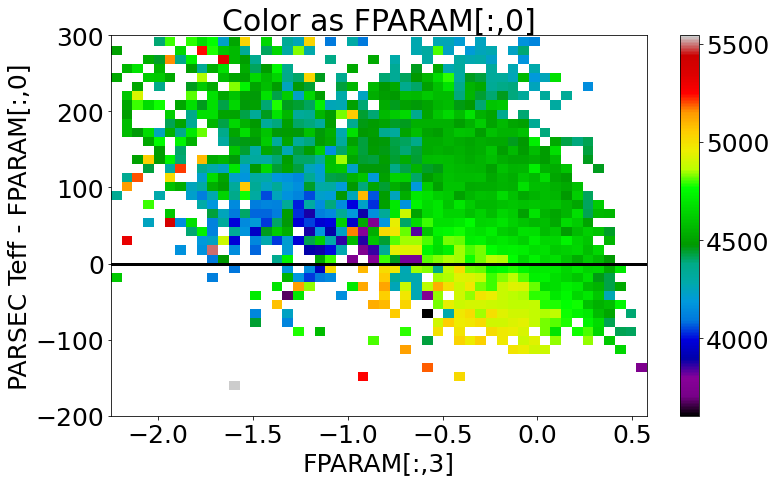

In [226]:
fincut = np.where((np.isfinite(rgb[low_ak]['FPARAM'][:,0])==True)&(np.isfinite(photteff)==True)&
                  (np.isfinite(rgb_salfeh[low_ak])==True)&(photteff-rgb[low_ak]['FPARAM'][:,0]>-300)&
                  (photteff-rgb[low_ak]['FPARAM'][:,0]<300))

plt.figure(figsize=[12,7])

ret = binned_statistic_2d(rgb[low_ak]['FPARAM'][:,3][fincut],(photteff-rgb[low_ak]['FPARAM'][:,0])[fincut],
                          rgb[low_ak]['FPARAM'][:,0][fincut],'median',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='nipy_spectral')

plt.colorbar()
plt.axhline(0.,c='k',lw=3.)
plt.ylim(-200,300)

plt.title(r'Color as FPARAM[:,0]')
plt.xlabel(r'FPARAM[:,3]')
plt.ylabel(r'PARSEC Teff - FPARAM[:,0]');

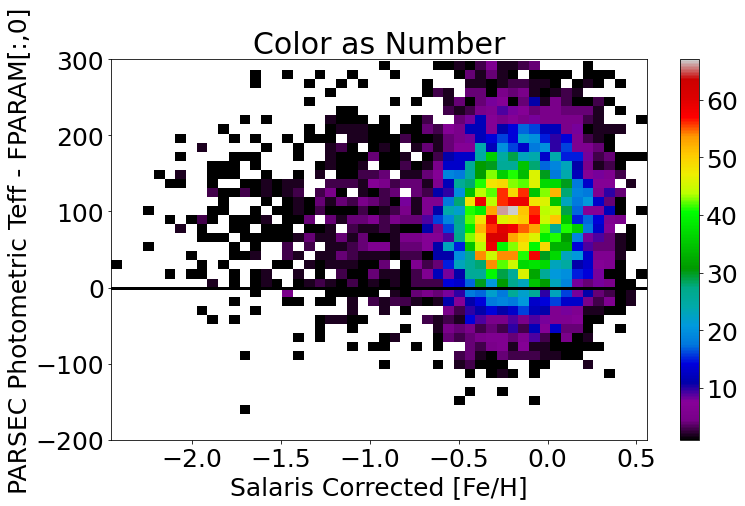

In [135]:
plt.figure(figsize=[12,7])

ret = binned_statistic_2d(rgb_salfeh[low_ak][fincut],(photteff-rgb[low_ak]['FPARAM'][:,0])[fincut],
                          rgb_salfeh[low_ak][fincut],'count',bins=50)
ret.statistic[ret.statistic == 0.0] = np.nan

im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='nipy_spectral')

plt.colorbar()
plt.axhline(0.,c='k',lw=3.)
plt.ylim(-200,300)

plt.xlabel(r'Salaris Corrected [Fe/H]')
plt.title(r'Color as Number')
plt.ylabel(r'PARSEC Photometric Teff - FPARAM[:,0]');

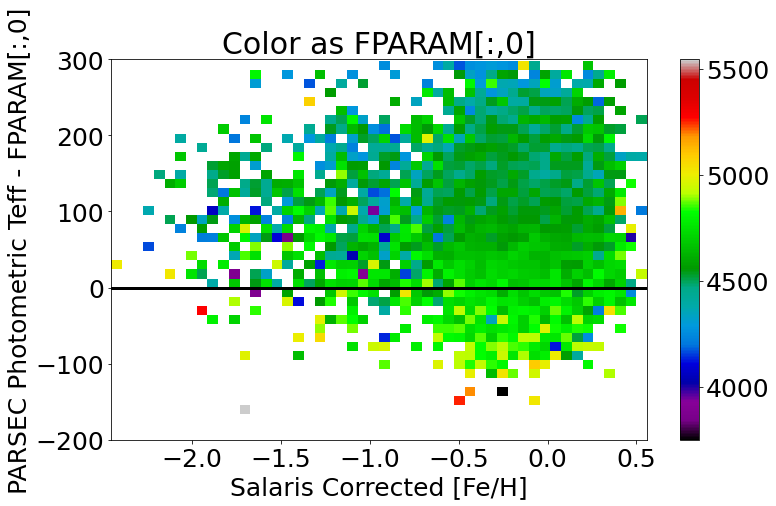

In [128]:
plt.figure(figsize=[12,7])

ret = binned_statistic_2d(rgb_salfeh[low_ak][fincut],(photteff-rgb[low_ak]['FPARAM'][:,0])[fincut],
                          rgb[low_ak]['FPARAM'][:,0][fincut],'median',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='nipy_spectral')

plt.colorbar()
plt.axhline(0.,c='k',lw=3.)
plt.ylim(-200,300)

plt.xlabel(r'Salaris Corrected [Fe/H]')
plt.title(r'Color as FPARAM[:,0]')
plt.ylabel(r'PARSEC Photometric Teff - FPARAM[:,0]');

In [149]:
# fincut = np.where((np.isfinite(rgb[low_ak]['FPARAM'][:,1])==True)&(np.isfinite(photteff)==True)&
#                   (np.isfinite(rgb_salfeh[low_ak])==True)&(photteff-rgb[low_ak]['FPARAM'][:,0]>-300)&
#                   (photteff-rgb[low_ak]['FPARAM'][:,0]<300))

# plt.figure(figsize=[12,7])

# # meds,edgs,_ = binned_statistic(rgb[low_ak]['FPARAM'][:,1][fincut],(photteff-rgb[low_ak]['FPARAM'][:,0])[fincut],
# #                                bins=50)

# # cens = edgs[:-1]+np.median(np.diff(edgs)/2)

# plt.scatter(rgb[low_ak]['FPARAM'][:,1][fincut],(photteff-rgb[low_ak]['FPARAM'][:,0])[fincut])
# # plt.hlines(meds, edgs[:-1], edgs[1:], colors='r', lw=5.)

# # plt.colorbar()
# plt.axhline(0.,c='k',lw=3.)
# plt.ylim(-200,300)

# plt.title(r'Color as Number')
# plt.xlabel(r'FPARAM[:,1]')
# plt.ylabel(r'PARSEC Photometric Teff - FPARAM[:,0]');

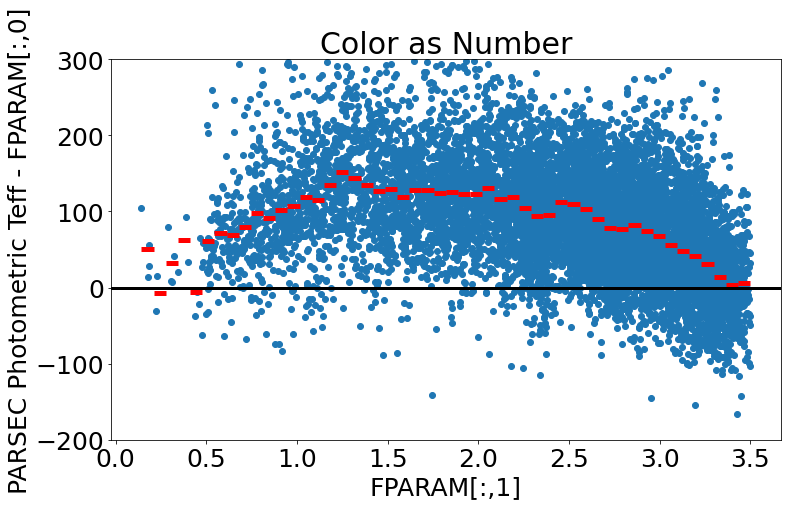

In [147]:
fincut = np.where((np.isfinite(rgb[low_ak]['FPARAM'][:,1])==True)&(np.isfinite(photteff)==True)&
                  (np.isfinite(rgb_salfeh[low_ak])==True)&(photteff-rgb[low_ak]['FPARAM'][:,0]>-300)&
                  (photteff-rgb[low_ak]['FPARAM'][:,0]<300))

plt.figure(figsize=[12,7])

meds,edgs,_ = binned_statistic(rgb[low_ak]['FPARAM'][:,1][fincut],(photteff-rgb[low_ak]['FPARAM'][:,0])[fincut],
                               bins=50)

# cens = edgs[:-1]+np.median(np.diff(edgs)/2)

plt.scatter(rgb[low_ak]['FPARAM'][:,1][fincut],(photteff-rgb[low_ak]['FPARAM'][:,0])[fincut])
plt.hlines(meds, edgs[:-1], edgs[1:], colors='r', lw=5.)

# plt.colorbar()
plt.axhline(0.,c='k',lw=3.)
plt.ylim(-200,300)

plt.title(r'Color as Number')
plt.xlabel(r'FPARAM[:,1]')
plt.ylabel(r'PARSEC Photometric Teff - FPARAM[:,0]');

In [119]:
i=0
np.array([[rgb[low_ak]['GAIAEDR3_PHOT_BP_MEAN_MAG'][i],
                    rgb[low_ak]['GAIAEDR3_PHOT_G_MEAN_MAG'][i],
                    rgb[low_ak]['GAIAEDR3_PHOT_RP_MEAN_MAG'][i],
                    rgb[low_ak]['J'][i],rgb[low_ak]['H'][i],
                    rgb[low_ak]['K'][i]],
                   [bperr[low_ak][i],gerr[low_ak][i],rperr[low_ak][i],
                    rgb[low_ak]['J_ERR'][i],rgb[low_ak]['H_ERR'][i],
                    rgb[low_ak]['K_ERR'][i]]]).T

array([[1.35080004e+01, 2.90424624e-03],
       [1.30397997e+01, 2.75532020e-03],
       [1.24087000e+01, 3.81745873e-03],
       [1.16379995e+01, 2.30000000e-02],
       [1.11459999e+01, 2.50000004e-02],
       [1.10590000e+01, 2.09999997e-02]])

In [103]:
# dicts = {}
# keys = np.unique(massive['MH'])
# values = np.ones(len(keys))
# for i in keys:
#         dicts[i] = values
# print(dicts)

In [91]:
len(np.unique(massive['MH']))

135

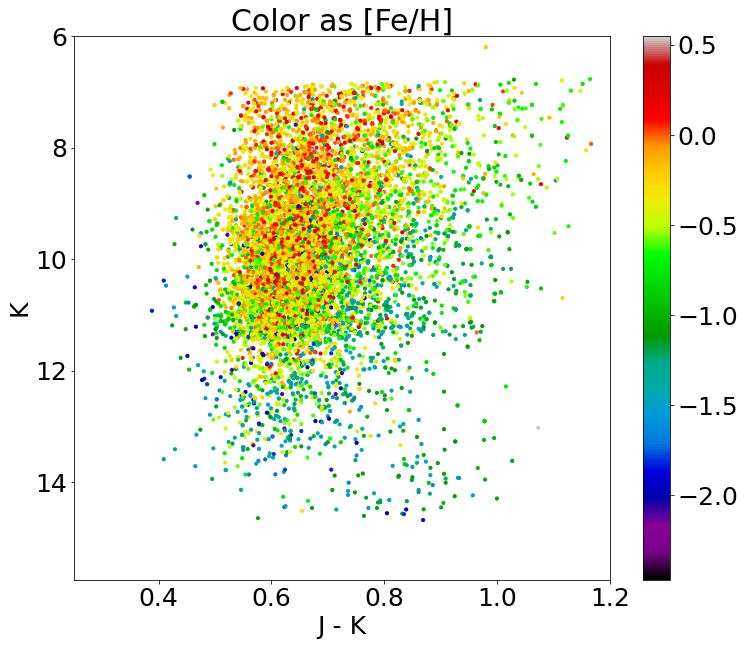

In [35]:
plt.figure(figsize=[12,10])
plt.scatter((rgb['J']-rgb['K'])[low_ak],rgb['K'][low_ak],c=rgb['FE_H'][low_ak],cmap='nipy_spectral',s=10)
plt.colorbar()

plt.xlim(0.25,1.2)
plt.ylim(6,15.75)
plt.gca().invert_yaxis()

plt.title(r'Color as [Fe/H]')
plt.xlabel(r'J - K')
plt.ylabel(r'K');

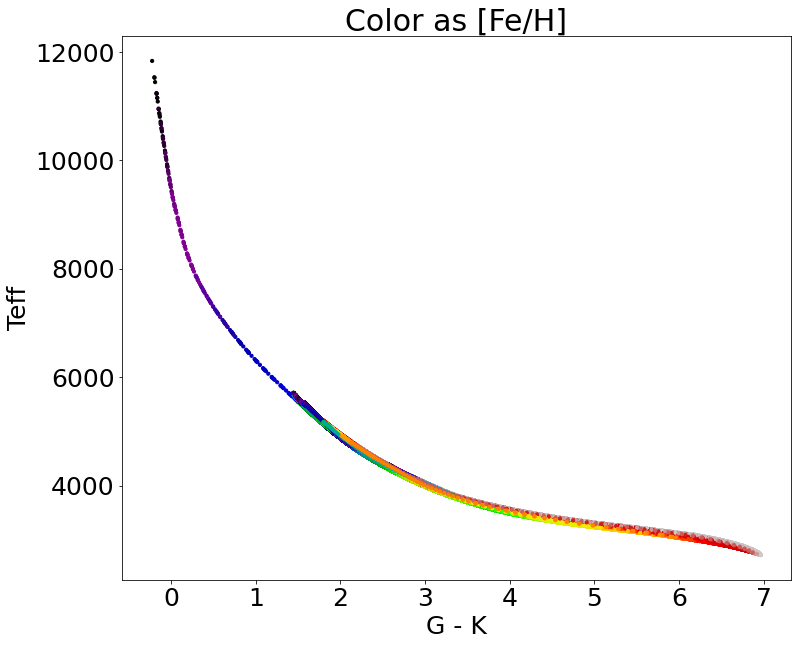

In [36]:
plt.figure(figsize=[12,10])
plt.scatter(massive['Gmag']-massive['Ksmag'],10**massive['logTe'],c=massive['MH'],cmap='nipy_spectral',s=10)

plt.title(r'Color as [Fe/H]')
plt.xlabel(r'G - K')
plt.ylabel(r'Teff');

In [37]:
max(dr17['TEFF'])

19869.988

In [38]:
def color_teff(X,b0,b1,b2,b3,b4,b5):
    '''
    Calculate 5040/teff
    '''
    color,mh = X
    return b0+b1*color+b2*(color**2)+b3*(color*mh)+b4*mh+b5*(mh**2)

poptbpg,_ = curve_fit(color_teff,(massive['G_BPmag']-massive['Gmag'],massive['MH']),5040/(10**massive['logTe']))
poptgrp,_ = curve_fit(color_teff,(massive['Gmag']-massive['G_RPmag'],massive['MH']),5040/(10**massive['logTe']))
poptgj,_ = curve_fit(color_teff,(massive['Gmag']-massive['Jmag'],massive['MH']),5040/(10**massive['logTe']))
poptgh,_ = curve_fit(color_teff,(massive['Gmag']-massive['Hmag'],massive['MH']),5040/(10**massive['logTe']))
poptgk,_ = curve_fit(color_teff,(massive['Gmag']-massive['Ksmag'],massive['MH']),5040/(10**massive['logTe']))

poptjk,_ = curve_fit(color_teff,(massive['Jmag']-massive['Ksmag'],massive['MH']),5040/(10**massive['logTe']))

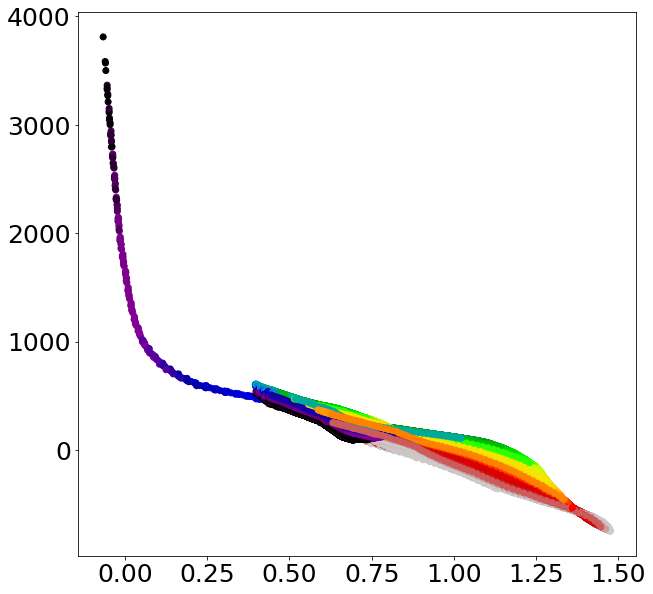

In [39]:
plt.figure(figsize=[10,10])
plt.scatter(massive['Jmag']-massive['Ksmag'],
            10**massive['logTe']-5040/color_teff((massive['Jmag']-massive['Ksmag'],massive['MH']),*poptbpg),
            c=massive['MH'],cmap='nipy_spectral')
plt.show()

(array([1.41000e+02, 4.60000e+01, 1.01919e+05, 9.46415e+05, 7.44516e+05,
        4.60475e+05, 2.53470e+05, 1.23186e+05, 6.11370e+04, 3.79480e+04,
        2.71400e+04, 2.11320e+04, 1.79120e+04, 1.57990e+04, 1.35090e+04,
        1.24600e+04, 1.12230e+04, 9.91600e+03, 9.07200e+03, 9.64600e+03,
        1.02940e+04, 1.15390e+04, 2.10870e+04, 1.71210e+04, 1.48300e+03]),
 array([-0.049  ,  0.08272,  0.21444,  0.34616,  0.47788,  0.6096 ,
         0.74132,  0.87304,  1.00476,  1.13648,  1.2682 ,  1.39992,
         1.53164,  1.66336,  1.79508,  1.9268 ,  2.05852,  2.19024,
         2.32196,  2.45368,  2.5854 ,  2.71712,  2.84884,  2.98056,
         3.11228,  3.244  ]),
 <a list of 25 Patch objects>)

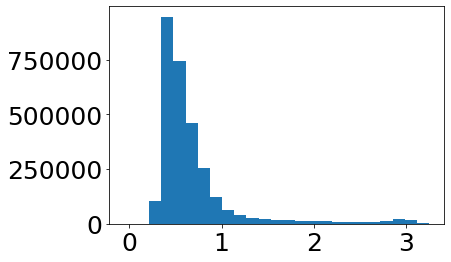

In [40]:
plt.hist(massive['G_BPmag']-massive['Gmag'],bins=25)

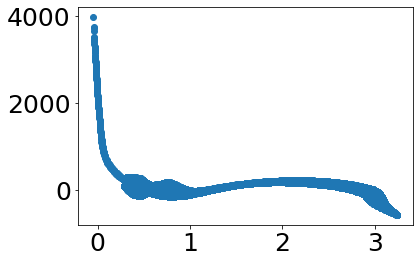

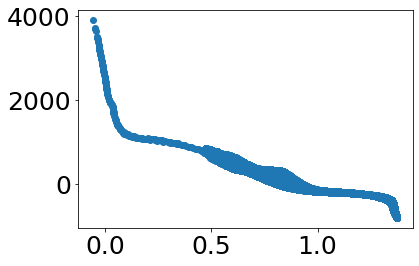

In [41]:
plt.scatter(massive['G_BPmag']-massive['Gmag'],
            10**massive['logTe']-5040/color_teff((massive['G_BPmag']-massive['Gmag'],massive['MH']),*poptbpg))
plt.show()

plt.scatter(massive['Gmag']-massive['G_RPmag'],
            10**massive['logTe']-5040/color_teff((massive['Gmag']-massive['G_RPmag'],massive['MH']),*poptbpg))
plt.show()

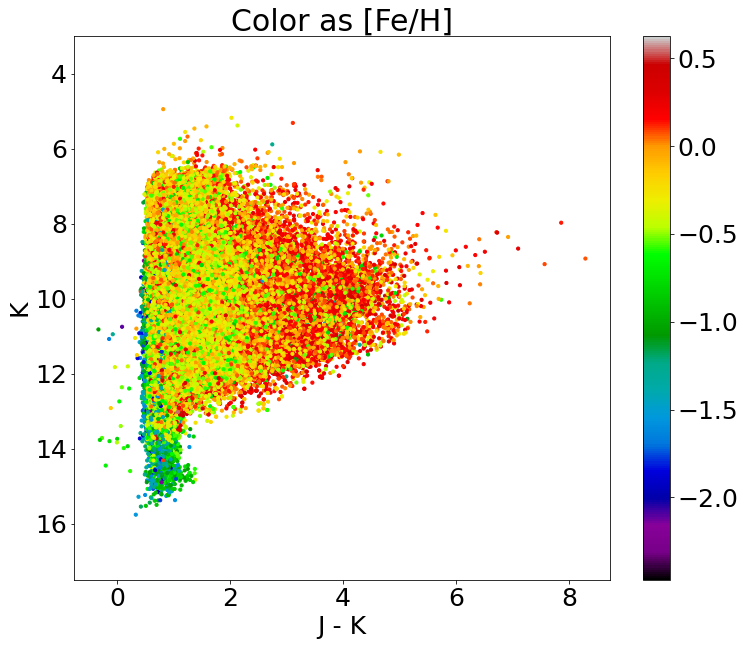

In [42]:
plt.figure(figsize=[12,10])
plt.scatter(rgb['J']-rgb['K'],rgb['K'],c=rgb['FE_H'],cmap='nipy_spectral',s=10)
plt.colorbar()

plt.ylim(3,17.5)
plt.gca().invert_yaxis()

plt.title(r'Color as [Fe/H]')
plt.xlabel(r'J - K')
plt.ylabel(r'K');

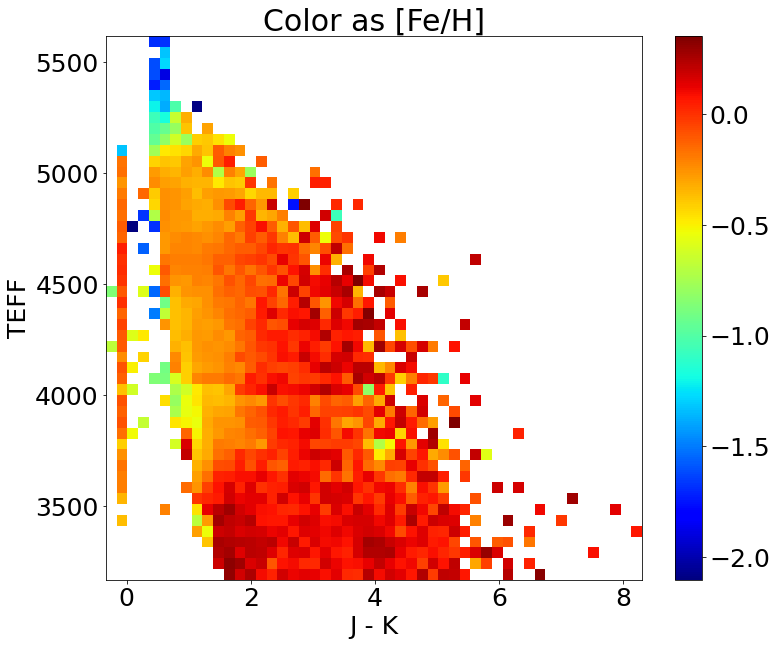

In [43]:
fincut = np.where((np.isfinite(rgb['J'])==True)&(np.isfinite(rgb['K'])==True)&
                  (np.isfinite(rgb['TEFF'])==True)&np.isfinite(rgb['FE_H'])==True) 

ret = binned_statistic_2d((rgb['J']-rgb['K'])[fincut],rgb['TEFF'][fincut],rgb['FE_H'][fincut],'median',bins=50)
ret.statistic[ret.statistic == 0.0] = np.nan

plt.figure(figsize=[12,10])
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='jet')

plt.colorbar()

plt.title(r'Color as [Fe/H]')
plt.xlabel(r'J - K')
plt.ylabel(r'TEFF');

In [44]:
# for i in np.unique(dr17['ASPCAPFLAGS']):
#     print(i.split(','))

(array([1.44869e+05, 3.39210e+04, 1.34530e+04, 5.78400e+03, 2.94700e+03,
        2.04800e+03, 1.44700e+03, 9.49000e+02, 8.67000e+02, 6.02000e+02,
        3.60000e+02, 2.20000e+02, 1.09000e+02, 5.10000e+01, 1.70000e+01,
        9.00000e+00, 5.00000e+00, 3.00000e+00, 2.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00]),
 array([0.   , 0.192, 0.384, 0.576, 0.768, 0.96 , 1.152, 1.344, 1.536,
        1.728, 1.92 , 2.112, 2.304, 2.496, 2.688, 2.88 , 3.072, 3.264,
        3.456, 3.648, 3.84 , 4.032, 4.224, 4.416, 4.608, 4.8  ],
       dtype=float32),
 <a list of 25 Patch objects>)

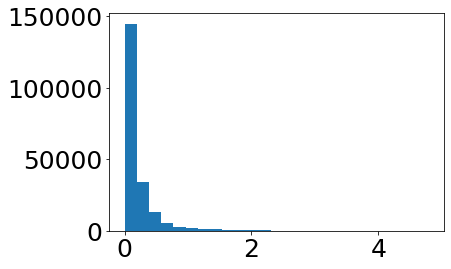

In [45]:
plt.hist(rgb['AK_TARG'],range=(0,4.8),bins=25)

In [46]:
max(rgb['AK_TARG'])
min(rgb['AK_TARG'])

-85.82749

(-0.1, 2.0)

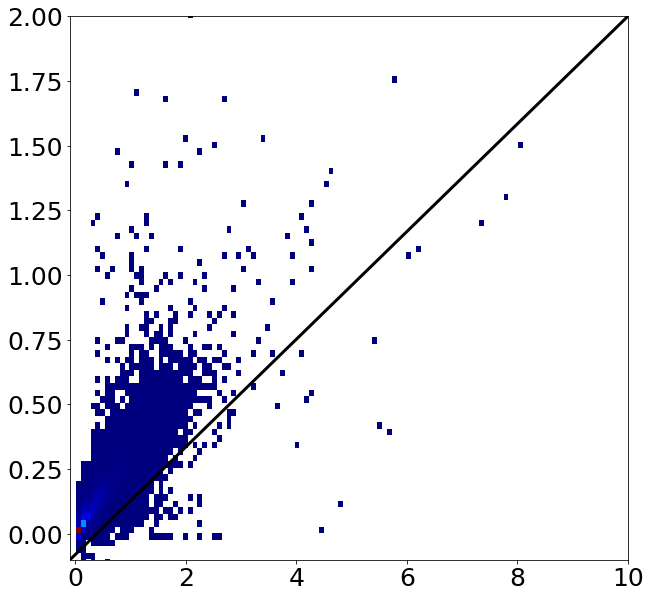

In [47]:
fincut = np.where((np.isfinite(rgb['SFD_EBV'])==True)&(np.isfinite(rgb['AK_TARG'])==True)) 

ret = binned_statistic_2d(rgb['SFD_EBV'][fincut],rgb['AK_TARG'][fincut],rgb['SFD_EBV'][fincut],'count',bins=500)
ret.statistic[ret.statistic == 0.0] = np.nan

plt.figure(figsize=[10,10])
# plt.scatter(rgb['SFD_EBV'],rgb['AK_TARG'],s=10)
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='jet')
plt.plot([-0.1,10],[-0.1,2],lw=3.0,c='k')
plt.xlim(-0.1,10)
plt.ylim(-0.1,2)

(0.0, 0.25)

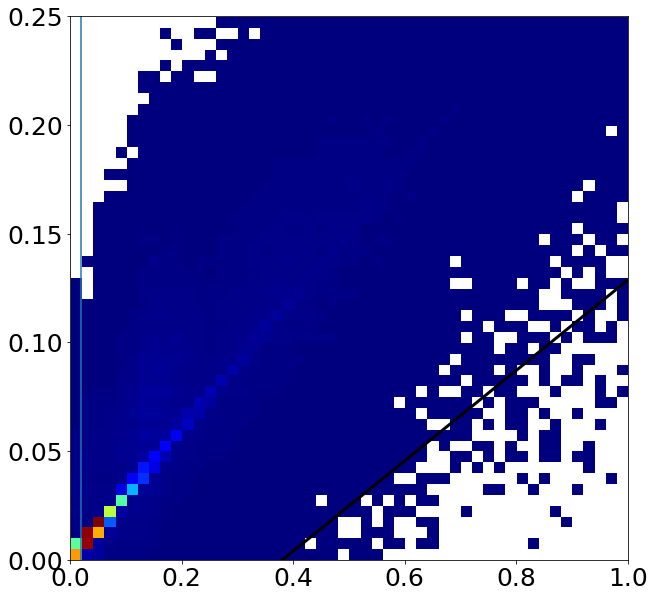

In [48]:
fincut = np.where((np.isfinite(rgb['SFD_EBV'])==True)&(np.isfinite(rgb['AK_TARG'])==True)&
                  (rgb['SFD_EBV']<1)&(rgb['SFD_EBV']>0)&(rgb['AK_TARG']<0.25)&(rgb['AK_TARG']>0)) 

ret = binned_statistic_2d(rgb['SFD_EBV'][fincut],rgb['AK_TARG'][fincut],rgb['SFD_EBV'][fincut],'count',bins=50)
ret.statistic[ret.statistic == 0.0] = np.nan

plt.figure(figsize=[10,10])
# plt.scatter(rgb['SFD_EBV'],rgb['AK_TARG'],s=10)
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='jet')
plt.plot([-0.1,10],[-0.1,2],lw=3.0,c='k')
plt.axvline(0.02)
plt.xlim(0,1)
plt.ylim(0,0.25)